# Student Performance Prediction
this notebook predicts the performance of a student based on dataset

# Import Libraries and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from statsmodels.regression.linear_model import OLS
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy import stats
from sklearn.metrics import r2_score
from scipy.stats import jarque_bera, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import KFold
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import itertools
import requests
import zipfile
import os
import io
import base64
from io import BytesIO
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [2]:
import requests
import zipfile
import os
import io
import pandas as pd

math_df = pd.read_csv("https://hc-cdn.hel1.your-objectstorage.com/s/v3/f4af50cca767b6e0a39366151c4f6fd8bcebc9ee_student-por.csv", sep=';')
port_df = pd.read_csv("https://hc-cdn.hel1.your-objectstorage.com/s/v3/7469c3f1d2735680fefe00ca2e4c44dbb8294b55_student-mat.csv", sep=';')

math_df['subject'] = 'math'
port_df['subject'] = 'portuguese'
df = pd.concat([math_df, port_df], ignore_index=True)

print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")
print(f"Target variable (G3) statistics:")
print(df['G3'].describe())

Dataset shape: (1044, 34)
Missing values: 0
Target variable (G3) statistics:
count    1044.000000
mean       11.341954
std         3.864796
min         0.000000
25%        10.000000
50%        11.000000
75%        14.000000
max        20.000000
Name: G3, dtype: float64


# Data Exploration

Data Types:
object    18
int64     16
Name: count, dtype: int64

Unique values in categorical columns:
school: 2 unique values
sex: 2 unique values
address: 2 unique values
famsize: 2 unique values
Pstatus: 2 unique values
Mjob: 5 unique values
Fjob: 5 unique values
reason: 4 unique values
guardian: 3 unique values
schoolsup: 2 unique values
famsup: 2 unique values
paid: 2 unique values
activities: 2 unique values
nursery: 2 unique values
higher: 2 unique values
internet: 2 unique values
romantic: 2 unique values
subject: 2 unique values


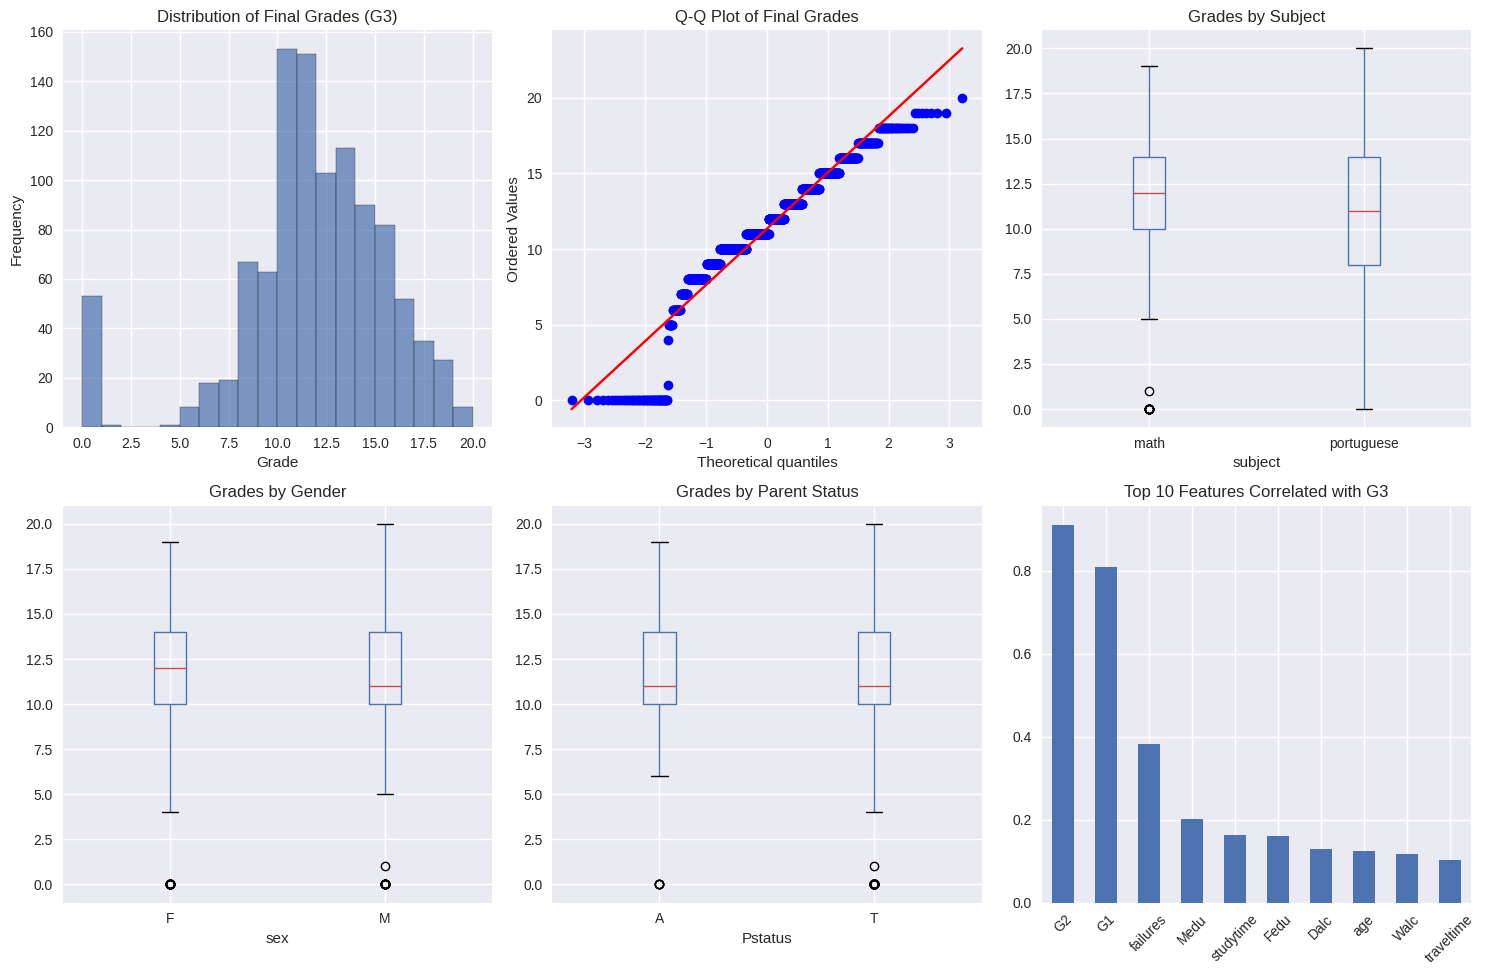

In [3]:
print("Data Types:")
print(df.dtypes.value_counts())
print("\nUnique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"{col}: {df[col].nunique()} unique values")

plt.figure(figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.hist(df['G3'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Distribution of Final Grades (G3)')
plt.xlabel('Grade')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
stats.probplot(df['G3'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Final Grades')

plt.subplot(2, 3, 3)
df.boxplot(column='G3', by='subject', ax=plt.gca())
plt.title('Grades by Subject')
plt.suptitle('')

plt.subplot(2, 3, 4)
df.boxplot(column='G3', by='sex', ax=plt.gca())
plt.title('Grades by Gender')
plt.suptitle('')

plt.subplot(2, 3, 5)
df.boxplot(column='G3', by='Pstatus', ax=plt.gca())
plt.title('Grades by Parent Status')
plt.suptitle('')

plt.subplot(2, 3, 6)
numerical_df = df.select_dtypes(include=[np.number])
correlation_with_target = numerical_df.corr()['G3'].abs().sort_values(ascending=False)[1:11]
correlation_with_target.plot(kind='bar')
plt.title('Top 10 Features Correlated with G3')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Statistical Tests and Distribution Analysis

In [4]:
jb_stat, jb_pvalue = jarque_bera(df['G3'])
shapiro_stat, shapiro_pvalue = stats.shapiro(df['G3'])
ks_stat, ks_pvalue = stats.kstest(df['G3'], 'norm', args=(df['G3'].mean(), df['G3'].std()))

print("Normality Tests for Target Variable (G3):")
print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.4f}")
print(f"Shapiro-Wilk test: statistic={shapiro_stat:.4f}, p-value={shapiro_pvalue:.4f}")
print(f"Kolmogorov-Smirnov test: statistic={ks_stat:.4f}, p-value={ks_pvalue:.4f}")

print("\nStatistical Tests Between Groups:")
male_grades = df[df['sex'] == 'M']['G3']
female_grades = df[df['sex'] == 'F']['G3']
t_stat, t_pvalue = stats.ttest_ind(male_grades, female_grades)
print(f"T-test (Male vs Female): t-statistic={t_stat:.4f}, p-value={t_pvalue:.4f}")

urban_grades = df[df['address'] == 'U']['G3']
rural_grades = df[df['address'] == 'R']['G3']
u_stat, u_pvalue = stats.mannwhitneyu(urban_grades, rural_grades)
print(f"Mann-Whitney U test (Urban vs Rural): U-statistic={u_stat:.4f}, p-value={u_pvalue:.4f}")

school_groups = [group['G3'].values for name, group in df.groupby('school')]
f_stat, f_pvalue = stats.f_oneway(*school_groups)
print(f"ANOVA (Schools): F-statistic={f_stat:.4f}, p-value={f_pvalue:.4f}")

Normality Tests for Target Variable (G3):
Jarque-Bera test: statistic=298.8906, p-value=0.0000
Shapiro-Wilk test: statistic=0.9183, p-value=0.0000
Kolmogorov-Smirnov test: statistic=0.1439, p-value=0.0000

Statistical Tests Between Groups:
T-test (Male vs Female): t-statistic=-1.0164, p-value=0.3097
Mann-Whitney U test (Urban vs Rural): U-statistic=126790.0000, p-value=0.0000
ANOVA (Schools): F-statistic=17.1131, p-value=0.0000


# Correlation and Relationship Analysis

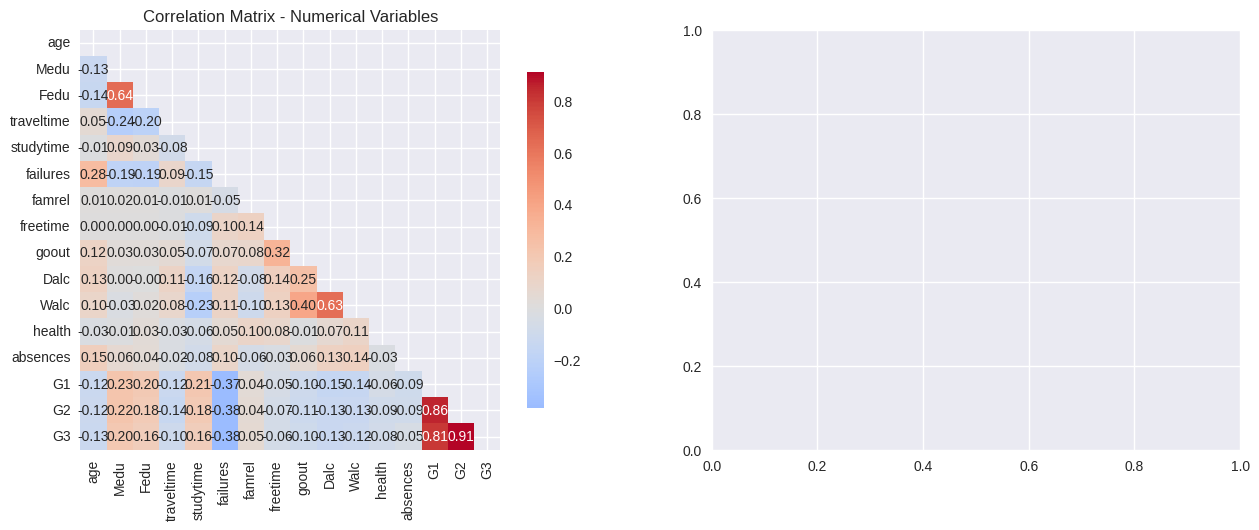

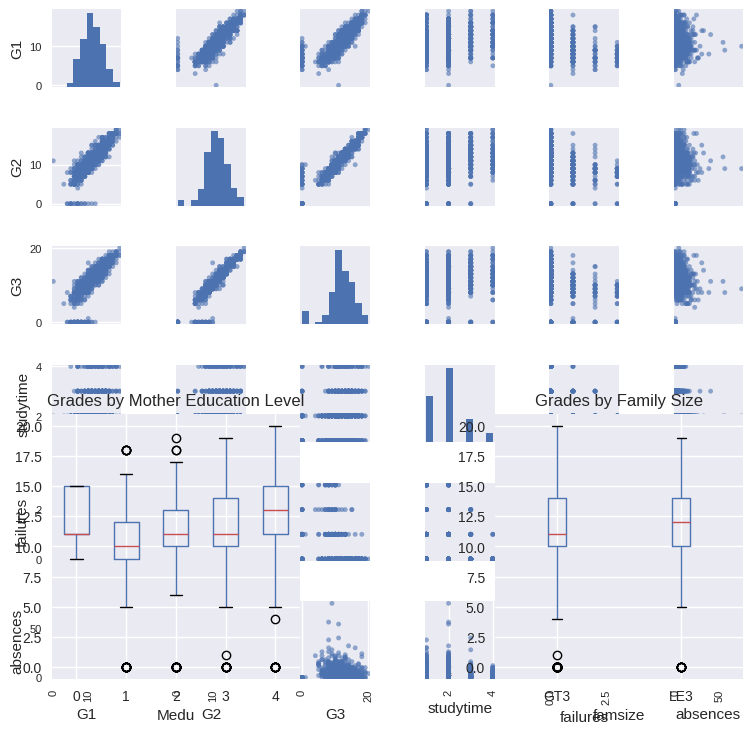

In [5]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numerical_cols].corr()

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Correlation Matrix - Numerical Variables')

key_vars = ['G1', 'G2', 'G3', 'studytime', 'failures', 'absences']
plt.subplot(2, 2, 2)
pd.plotting.scatter_matrix(df[key_vars], alpha=0.6, figsize=(8, 8), diagonal='hist')
plt.suptitle('Scatter Plot Matrix - Key Variables')

plt.subplot(2, 2, 3)
df.boxplot(column='G3', by='Medu', ax=plt.gca())
plt.title('Grades by Mother Education Level')
plt.suptitle('')

plt.subplot(2, 2, 4)
df.boxplot(column='G3', by='famsize', ax=plt.gca())
plt.title('Grades by Family Size')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Feature Engineering

In [6]:
df_processed = df.copy()

df_processed['grade_category'] = pd.cut(df_processed['G3'],
                                       bins=[0, 10, 15, 20],
                                       labels=['Low', 'Medium', 'High'], right=False)

df_processed['total_study_time'] = df_processed['studytime'] + df_processed['freetime']
df_processed['parent_education_avg'] = (df_processed['Medu'] + df_processed['Fedu']) / 2
df_processed['grade_trend'] = df_processed['G2'] - df_processed['G1']
df_processed['attendance_ratio'] = 1 - (df_processed['absences'] / df_processed['absences'].max())
df_processed['support_index'] = (df_processed['schoolsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['famsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['paid'].map({'yes': 1, 'no': 0}))

df_processed['family_quality'] = df_processed['famrel'] + df_processed['Pstatus'].map({'T': 2, 'A': 0})
df_processed['social_factor'] = df_processed['goout'] + df_processed['Dalc'] + df_processed['Walc']

df_processed['motivation_score'] = (df_processed['higher'].map({'yes': 2, 'no': 0}) +
                                   df_processed['internet'].map({'yes': 1, 'no': 0}) +
                                   df_processed['romantic'].map({'yes': -1, 'no': 1}))

print("New features created:")
new_features = ['grade_category', 'total_study_time', 'parent_education_avg', 'grade_trend',
                'attendance_ratio', 'support_index', 'family_quality', 'social_factor', 'motivation_score']
for feature in new_features:
    print(f"{feature}: {df_processed[feature].describe()}")

key_numerical = ['G1', 'G2', 'studytime', 'absences', 'age']
poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_data = poly_features.fit_transform(df_processed[key_numerical])
poly_feature_names = poly_features.get_feature_names_out(key_numerical)

for i, name in enumerate(poly_feature_names):
    if name not in key_numerical:
        df_processed[f'poly_{name}'] = poly_data[:, i]

df_processed['study_health_interaction'] = df_processed['studytime'] * df_processed['health']
df_processed['family_support_interaction'] = df_processed['parent_education_avg'] * df_processed['support_index']
df_processed['age_failures_interaction'] = df_processed['age'] * (df_processed['failures'] + 1)
df_processed['social_academic_balance'] = df_processed['social_factor'] / (df_processed['studytime'] + 1)

df_processed['age_group'] = pd.cut(df_processed['age'], bins=3, labels=['Young', 'Medium', 'Old'], right=False)
df_processed['absence_level'] = pd.cut(df_processed['absences'],
                                      bins=[-1, 0, 5, 15, 100],
                                      labels=['None', 'Low', 'Medium', 'High'], right=False)

skewed_features = ['absences']
for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])

df_processed['g1_g2_ratio'] = df_processed['G1'] / (df_processed['G2'] + 1)
df_processed['study_absence_ratio'] = df_processed['studytime'] / (df_processed['absences'] + 1)

print(f"Total features after engineering: {df_processed.shape[1]}")
print(f"New polynomial features: {len([col for col in df_processed.columns if 'poly_' in col])}")

New features created:
grade_category: count       1043
unique         3
top       Medium
freq         610
Name: grade_category, dtype: object
total_study_time: count    1044.000000
mean        5.171456
std         1.263967
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: total_study_time, dtype: float64
parent_education_avg: count    1044.000000
mean        2.495690
std         1.007989
min         0.000000
25%         1.500000
50%         2.500000
75%         3.500000
max         4.000000
Name: parent_education_avg, dtype: float64
grade_trend: count    1044.000000
mean        0.032567
std         1.691129
min       -12.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max        11.000000
Name: grade_trend, dtype: float64
attendance_ratio: count    1044.000000
mean        0.940868
std         0.082800
min         0.000000
25%         0.920000
50%         0.973333
75%         1.000000
max         1.000000

# Data Visualization Dashboard

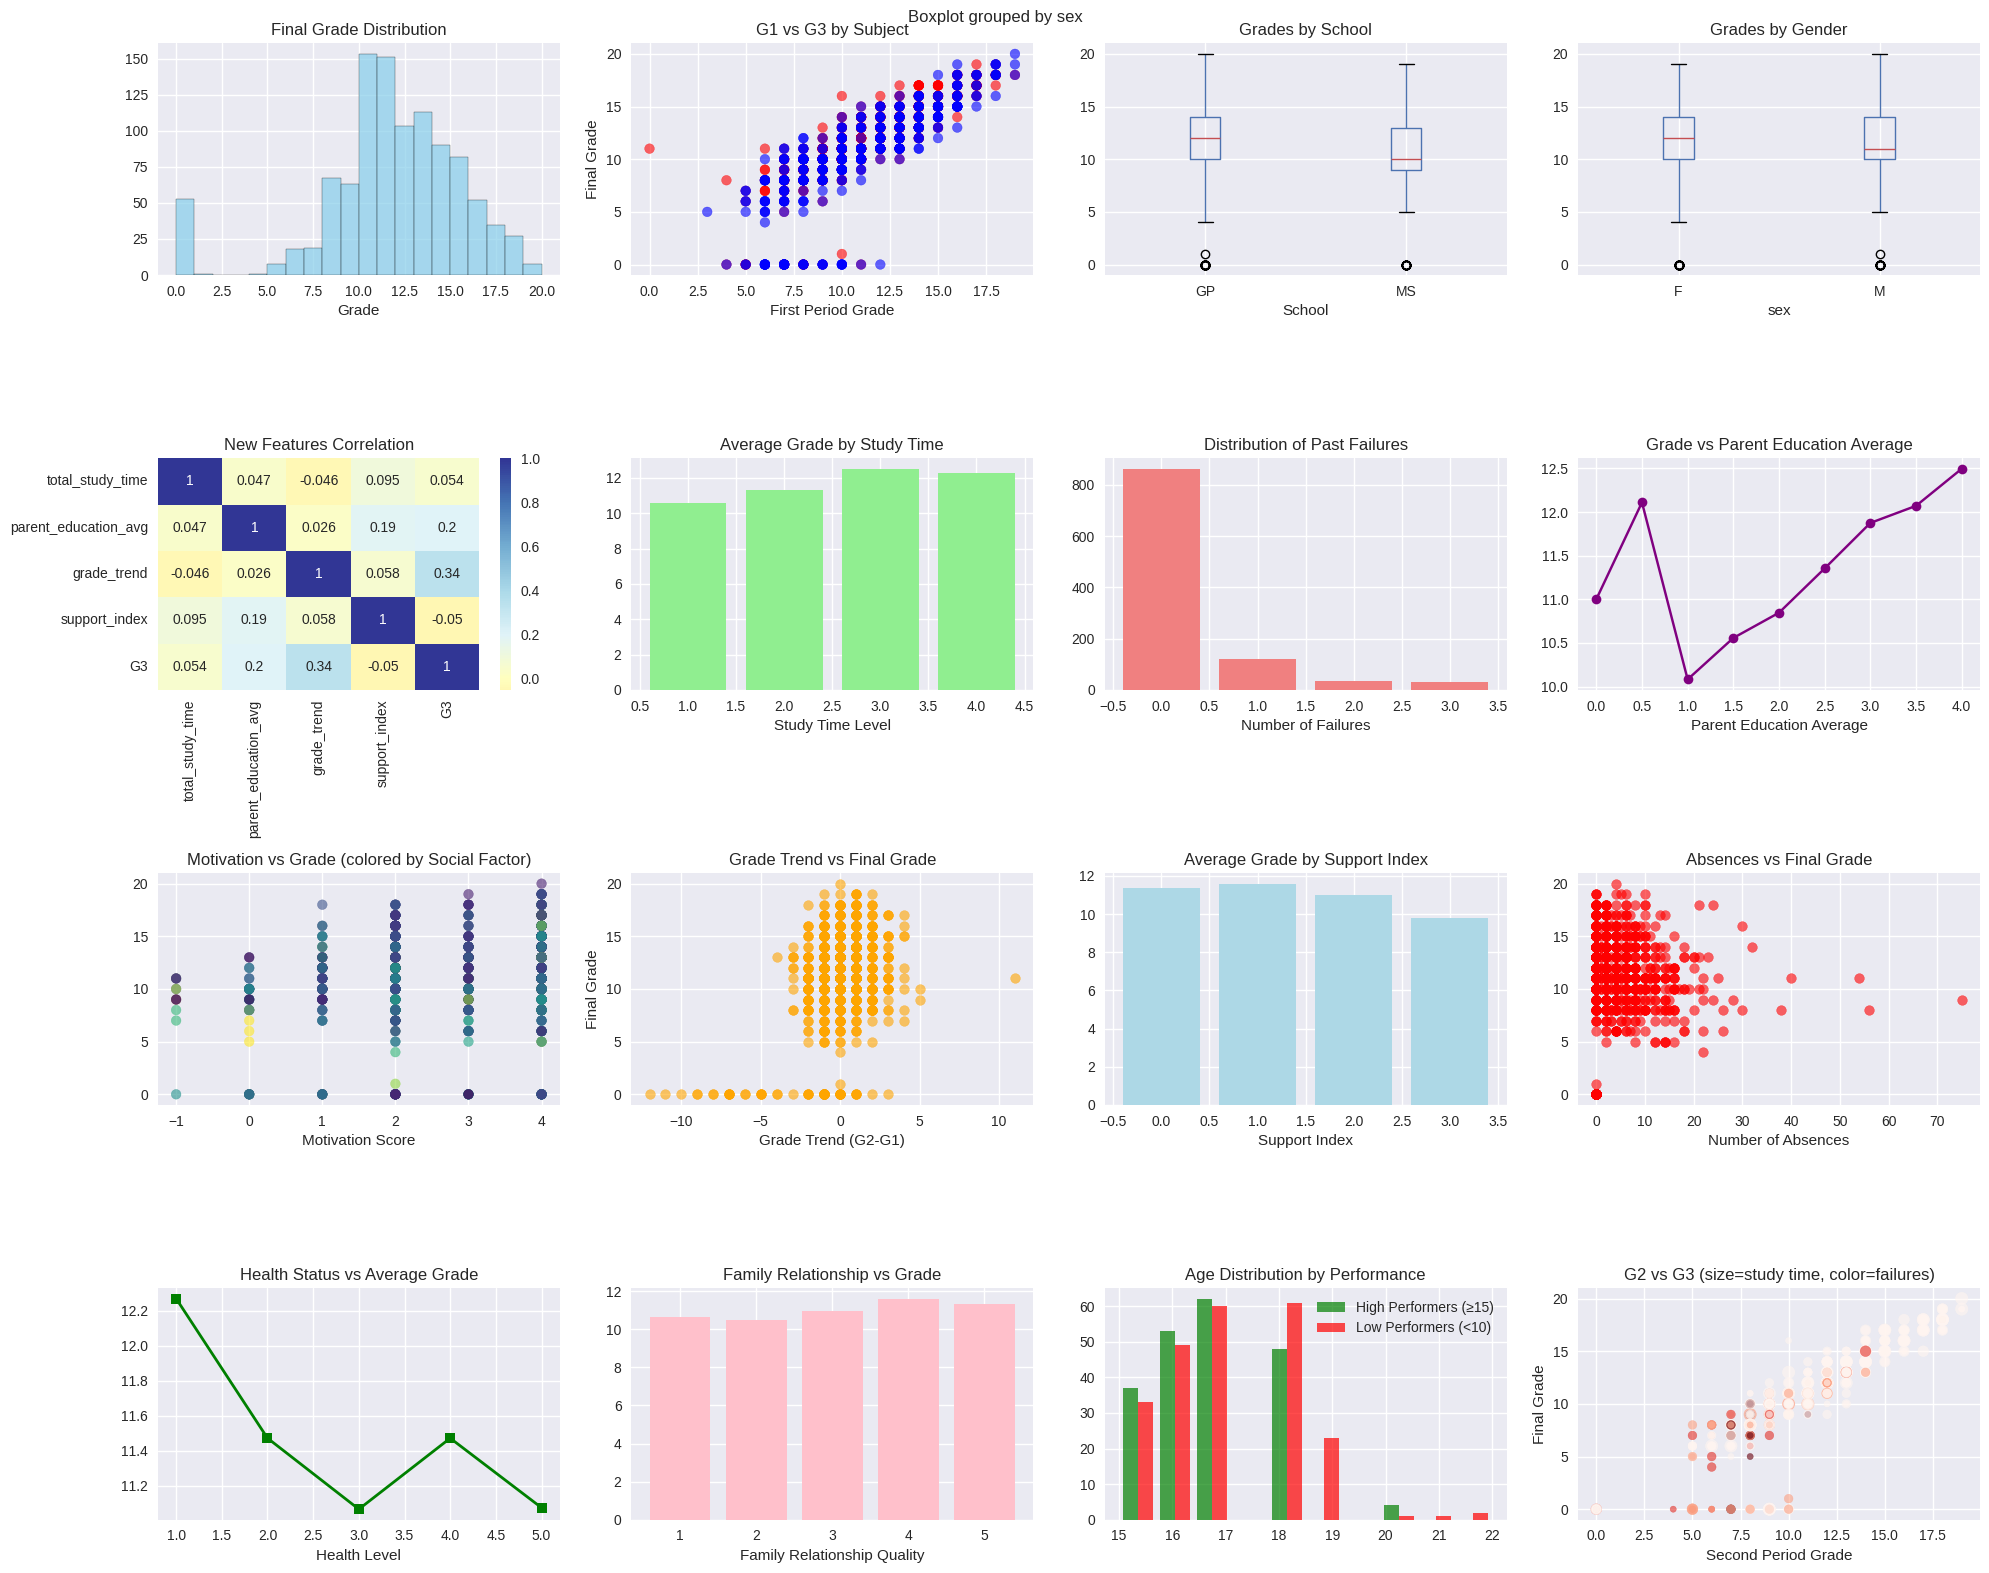

In [7]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Comprehensive Data Analysis Dashboard', fontsize=16)

axes[0, 0].hist(df_processed['G3'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Final Grade Distribution')
axes[0, 0].set_xlabel('Grade')

axes[0, 1].scatter(df_processed['G1'], df_processed['G3'], alpha=0.6, c=df_processed['subject'].map({'math': 'red', 'portuguese': 'blue'}))
axes[0, 1].set_title('G1 vs G3 by Subject')
axes[0, 1].set_xlabel('First Period Grade')
axes[0, 1].set_ylabel('Final Grade')

df_processed.boxplot(column='G3', by='school', ax=axes[0, 2])
axes[0, 2].set_title('Grades by School')
axes[0, 2].set_xlabel('School')

df_processed.boxplot(column='G3', by='sex', ax=axes[0, 3])
axes[0, 3].set_title('Grades by Gender')

new_numerical_features = ['total_study_time', 'parent_education_avg', 'grade_trend', 'support_index', 'G3']
corr_new = df_processed[new_numerical_features].corr()
sns.heatmap(corr_new, annot=True, cmap='RdYlBu', center=0, ax=axes[1, 0])
axes[1, 0].set_title('New Features Correlation')

study_time_grades = df_processed.groupby('studytime')['G3'].mean()
axes[1, 1].bar(study_time_grades.index, study_time_grades.values, color='lightgreen')
axes[1, 1].set_title('Average Grade by Study Time')
axes[1, 1].set_xlabel('Study Time Level')

failure_counts = df_processed['failures'].value_counts().sort_index()
axes[1, 2].bar(failure_counts.index, failure_counts.values, color='lightcoral')
axes[1, 2].set_title('Distribution of Past Failures')
axes[1, 2].set_xlabel('Number of Failures')

parent_edu_effect = df_processed.groupby('parent_education_avg')['G3'].mean()
axes[1, 3].plot(parent_edu_effect.index, parent_edu_effect.values, marker='o', color='purple')
axes[1, 3].set_title('Grade vs Parent Education Average')
axes[1, 3].set_xlabel('Parent Education Average')

axes[2, 0].scatter(df_processed['motivation_score'], df_processed['G3'],
                  c=df_processed['social_factor'], cmap='viridis', alpha=0.6)
axes[2, 0].set_title('Motivation vs Grade (colored by Social Factor)')
axes[2, 0].set_xlabel('Motivation Score')

axes[2, 1].scatter(df_processed['grade_trend'], df_processed['G3'], alpha=0.6, color='orange')
axes[2, 1].set_title('Grade Trend vs Final Grade')
axes[2, 1].set_xlabel('Grade Trend (G2-G1)')
axes[2, 1].set_ylabel('Final Grade')

support_grades = df_processed.groupby('support_index')['G3'].mean()
axes[2, 2].bar(support_grades.index, support_grades.values, color='lightblue')
axes[2, 2].set_title('Average Grade by Support Index')
axes[2, 2].set_xlabel('Support Index')

axes[2, 3].scatter(df_processed['absences'], df_processed['G3'], alpha=0.6, color='red')
axes[2, 3].set_title('Absences vs Final Grade')
axes[2, 3].set_xlabel('Number of Absences')

health_grades = df_processed.groupby('health')['G3'].mean()
axes[3, 0].plot(health_grades.index, health_grades.values, marker='s', color='green', linewidth=2)
axes[3, 0].set_title('Health Status vs Average Grade')
axes[3, 0].set_xlabel('Health Level')

famrel_grades = df_processed.groupby('famrel')['G3'].mean()
axes[3, 1].bar(famrel_grades.index, famrel_grades.values, color='pink')
axes[3, 1].set_title('Family Relationship vs Grade')
axes[3, 1].set_xlabel('Family Relationship Quality')

high_performers = df_processed[df_processed['G3'] >= 15]['age']
low_performers = df_processed[df_processed['G3'] < 10]['age']
axes[3, 2].hist([high_performers, low_performers], bins=10, alpha=0.7,
               label=['High Performers (≥15)', 'Low Performers (<10)'], color=['green', 'red'])
axes[3, 2].set_title('Age Distribution by Performance')
axes[3, 2].legend()

axes[3, 3].scatter(df_processed['G2'], df_processed['G3'],
                  s=df_processed['studytime']*20,
                  c=df_processed['failures'],
                  cmap='Reds', alpha=0.6)
axes[3, 3].set_title('G2 vs G3 (size=study time, color=failures)')
axes[3, 3].set_xlabel('Second Period Grade')
axes[3, 3].set_ylabel('Final Grade')

plt.tight_layout()
plt.show()

# Data Preprocessing and Scaling

In [8]:
target = 'G3'
features_to_drop = ['G3', 'grade_category']
categorical_features = df_processed.select_dtypes(include=['object']).columns.tolist()
categorical_features = [col for col in categorical_features if col not in features_to_drop]

df_encoded = df_processed.copy()
label_encoders = {}
for col in categorical_features:
    if df_encoded[col].dtype == 'bool':
        continue
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
    label_encoders[col] = le

high_cardinality_cats = ['reason', 'guardian', 'age_group', 'absence_level']
df_encoded = pd.get_dummies(df_encoded, columns=high_cardinality_cats, prefix=high_cardinality_cats)

X = df_encoded.drop(columns=features_to_drop)
y = df_encoded[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=pd.cut(y, bins=3, labels=False))

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Number of features: {X_train.shape[1]}")

scaler = StandardScaler()
numerical_cols_for_scaling = X_train.select_dtypes(include=np.number).columns
X_train_scaled = scaler.fit_transform(X_train[numerical_cols_for_scaling])
X_test_scaled = scaler.transform(X_test[numerical_cols_for_scaling])

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=numerical_cols_for_scaling, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=numerical_cols_for_scaling, index=X_test.index)

X_train_final = pd.concat([X_train_scaled_df, X_train.select_dtypes(include='bool')], axis=1)
X_test_final = pd.concat([X_test_scaled_df, X_test.select_dtypes(include='bool')], axis=1)

print("Data preprocessing completed")

Training set shape: (835, 70)
Test set shape: (209, 70)
Number of features: 70
Data preprocessing completed


# Model Definition and Hyperparameter Spaces

In [9]:
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {'fit_intercept': [True, False]}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10, 100],
            'solver': ['auto', 'svd', 'cholesky']
        }
    },
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.01, 0.1, 1, 10],
            'max_iter': [1000, 2000]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.01, 0.1, 1],
            'l1_ratio': [0.1, 0.5, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 10]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.1, 0.2],
            'max_depth': [3, 5]
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100],
            'learning_rate': [0.1, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],
            'C': [1, 10, 100],
            'gamma': ['scale', 'auto']
        }
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        }
    },
    'MLP': {
        'model': MLPRegressor(),
        'params': {
            'hidden_layer_sizes': [(50,), (100,)],
            'activation': ['relu', 'tanh'],
            'solver': ['adam', 'lbfgs'],
            'alpha': [0.0001, 0.001],
            'max_iter': [500, 1000]
        }
    }
}

print(f"Total models defined: {len(models)}")
print("Models:", list(models.keys()))

Total models defined: 11
Models: ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet', 'DecisionTree', 'RandomForest', 'GradientBoosting', 'AdaBoost', 'SVR', 'KNN', 'MLP']


# Model Training and Evaluation

In [10]:
results = {}
best_models = {}
cv_scores = {}

print("Starting model training and optimization...")
print("=" * 60)

for model_name, model_config in models.items():
    print(f"Training {model_name}...")

    try:
        random_search = RandomizedSearchCV(
            estimator=model_config['model'],
            param_distributions=model_config['params'],
            n_iter=20,
            cv= StratifiedKFold(n_splits=3, shuffle=True, random_state=42) if target in df_processed.columns and df_processed[target].nunique() > 10 else 3,
            scoring='r2',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        X_train_model = X_train_final
        X_test_model = X_test_final

        random_search.fit(X_train_model, y_train)

        best_models[model_name] = random_search.best_estimator_

        cv_scores[model_name] = random_search.cv_results_['mean_test_score']


        y_pred = random_search.best_estimator_.predict(X_test_model)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mse)

        mape = np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan).dropna())) * 100 if not y_test[y_test == 0].empty else np.nan
        max_error = np.max(np.abs(y_test - y_pred))

        results[model_name] = {
            'best_params': random_search.best_params_,
            'best_cv_score': random_search.best_score_,
            'test_mse': mse,
            'test_mae': mae,
            'test_r2': r2,
            'test_rmse': rmse,
            'test_mape': mape,
            'max_error': max_error,
            'predictions': y_pred
        }

        print(f"  Best CV R²: {random_search.best_score_:.4f}")
        print(f"  Test R²: {r2:.4f}")
        print(f"  Test RMSE: {rmse:.4f}")

    except Exception as e:
        print(f"  Error training {model_name}: {str(e)}")
        continue

print(f"\nModel training completed!")
print(f"Successfully trained {len(results)} models")

print("\nModel Performance Summary:")
print("-" * 60)
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV_R2': [results[model]['best_cv_score'] for model in results.keys()],
    'Test_R2': [results[model]['test_r2'] for model in results.keys()],
    'Test_RMSE': [results[model]['test_rmse'] for model in results.keys()],
    'Test_MAE': [results[model]['test_mae'] for model in results.keys()],
    'Test_MAPE': [results[model].get('test_mape', np.nan) for model in results.keys()],
    'Max_Error': [results[model]['max_error'] for model in results.keys()]
})

performance_df = performance_df.sort_values('Test_R2', ascending=False)
print(performance_df.round(4))

top_3_models = performance_df.head(3)['Model'].tolist()
print(f"\nTop 3 performing models: {top_3_models}")

Starting model training and optimization...
Training LinearRegression...
  Best CV R²: 0.8468
  Test R²: 0.7878
  Test RMSE: 1.7535
Training Ridge...
  Best CV R²: 0.8519
  Test R²: 0.7886
  Test RMSE: 1.7499
Training Lasso...
  Best CV R²: 0.8572
  Test R²: 0.7871
  Test RMSE: 1.7564
Training ElasticNet...
  Best CV R²: 0.8579
  Test R²: 0.7880
  Test RMSE: 1.7526
Training DecisionTree...
  Best CV R²: 0.8596
  Test R²: 0.7573
  Test RMSE: 1.8750
Training RandomForest...
  Best CV R²: 0.8764
  Test R²: 0.7748
  Test RMSE: 1.8062
Training GradientBoosting...
  Best CV R²: 0.8668
  Test R²: 0.7839
  Test RMSE: 1.7694
Training AdaBoost...
  Best CV R²: 0.8538
  Test R²: 0.7860
  Test RMSE: 1.7607
Training SVR...
  Best CV R²: 0.8394
  Test R²: 0.7764
  Test RMSE: 1.7998
Training KNN...
  Best CV R²: 0.6859
  Test R²: 0.6728
  Test RMSE: 2.1773
Training MLP...
  Best CV R²: 0.8260
  Test R²: 0.7705
  Test RMSE: 1.8233

Model training completed!
Successfully trained 11 models

Model Perfor

# Model Evaluation and Statistical Analysis

In [11]:
def evaluate_model_comprehensively(model_name, y_true, y_pred, model_obj):
    """Comprehensive model evaluation with statistical tests"""

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)

    residuals = y_true - y_pred

    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    jb_stat, jb_p = jarque_bera(residuals)

    try:
        ols_model = OLS(residuals, np.column_stack([np.ones(len(y_pred)), y_pred])).fit()
        bp_stat, bp_p, _, _ = het_breuschpagan(ols_model.resid, ols_model.model.exog)
    except:
        bp_stat, bp_p = np.nan, np.nan

    dw_stat = durbin_watson(residuals)

    explained_variance = r2
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)

    residual_std = np.std(residuals)
    prediction_intervals = {
        '95%': 1.96 * residual_std,
        '90%': 1.645 * residual_std,
        '68%': 1.0 * residual_std
    }

    feature_importance = None
    if hasattr(model_obj, 'feature_importances_'):
        feature_importance = model_obj.feature_importances_
    elif hasattr(model_obj, 'coef_'):
        feature_importance = np.abs(model_obj.coef_)

    evaluation_results = {
        'model_name': model_name,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'rmse': rmse,
        'shapiro_stat': shapiro_stat,
        'shapiro_p': shapiro_p,
        'jb_stat': jb_stat,
        'jb_p': jb_p,
        'bp_stat': bp_stat,
        'bp_p': bp_p,
        'dw_stat': dw_stat,
        'mean_residual': mean_residual,
        'std_residual': std_residual,
        'prediction_intervals': prediction_intervals,
        'feature_importance': feature_importance,
        'residuals': residuals
    }

    return evaluation_results

detailed_evaluations = {}
print("Detailed Model Evaluation Results:")
print("=" * 80)

for model_name in top_3_models:
    if model_name in results and model_name in best_models:
        y_pred = results[model_name]['predictions']
        model_obj = best_models[model_name]

        evaluation = evaluate_model_comprehensively(model_name, y_test, y_pred, model_obj)
        detailed_evaluations[model_name] = evaluation

        print(f"\n{model_name} Detailed Analysis:")
        print("-" * 50)
        print(f"R² Score: {evaluation['r2']:.4f}")
        print(f"RMSE: {evaluation['rmse']:.4f}")
        print(f"MAE: {evaluation['mae']:.4f}")
        print(f"Mean Residual: {evaluation['mean_residual']:.4f}")
        print(f"Residual Std: {evaluation['std_residual']:.4f}")
        print(f"Shapiro-Wilk p-value: {evaluation['shapiro_p']:.4f}")
        print(f"Jarque-Bera p-value: {evaluation['jb_p']:.4f}")
        print(f"Durbin-Watson stat: {evaluation['dw_stat']:.4f}")

        if not np.isnan(evaluation['bp_p']):
            print(f"Breusch-Pagan p-value: {evaluation['bp_p']:.4f}")

        print("Prediction Intervals:")
        for interval, value in evaluation['prediction_intervals'].items():
            print(f"  {interval}: ±{value:.4f}")

Detailed Model Evaluation Results:

Ridge Detailed Analysis:
--------------------------------------------------
R² Score: 0.7886
RMSE: 1.7499
MAE: 1.0762
Mean Residual: 0.0651
Residual Std: 1.7487
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 2.0985
Breusch-Pagan p-value: 0.0012
Prediction Intervals:
  95%: ±3.4275
  90%: ±2.8766
  68%: ±1.7487

ElasticNet Detailed Analysis:
--------------------------------------------------
R² Score: 0.7880
RMSE: 1.7526
MAE: 1.0210
Mean Residual: 0.0878
Residual Std: 1.7504
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 2.1126
Breusch-Pagan p-value: 0.0104
Prediction Intervals:
  95%: ±3.4309
  90%: ±2.8795
  68%: ±1.7504

LinearRegression Detailed Analysis:
--------------------------------------------------
R² Score: 0.7878
RMSE: 1.7535
MAE: 1.0935
Mean Residual: 0.0556
Residual Std: 1.7526
Shapiro-Wilk p-value: 0.0000
Jarque-Bera p-value: 0.0000
Durbin-Watson stat: 2.0980
Breusch-Pagan p-v

# Statistical comparison of top models

In [12]:
print("\nStatistical Comparison of Top Models:")
print("-" * 50)

if len(top_3_models) >= 2:
    model1_residuals = detailed_evaluations[top_3_models[0]]['residuals']
    model2_residuals = detailed_evaluations[top_3_models[1]]['residuals']

    t_stat, t_p = stats.ttest_rel(np.abs(model1_residuals), np.abs(model2_residuals))
    print(f"Paired t-test ({top_3_models[0]} vs {top_3_models[1]}):")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {t_p:.4f}")

    w_stat, w_p = stats.wilcoxon(np.abs(model1_residuals), np.abs(model2_residuals))
    print(f"Wilcoxon test:")
    print(f"  statistic: {w_stat:.4f}, p-value: {w_p:.4f}")


Statistical Comparison of Top Models:
--------------------------------------------------
Paired t-test (Ridge vs ElasticNet):
  t-statistic: 2.0046, p-value: 0.0463
Wilcoxon test:
  statistic: 9398.0000, p-value: 0.0721


# Visualization Dashboard

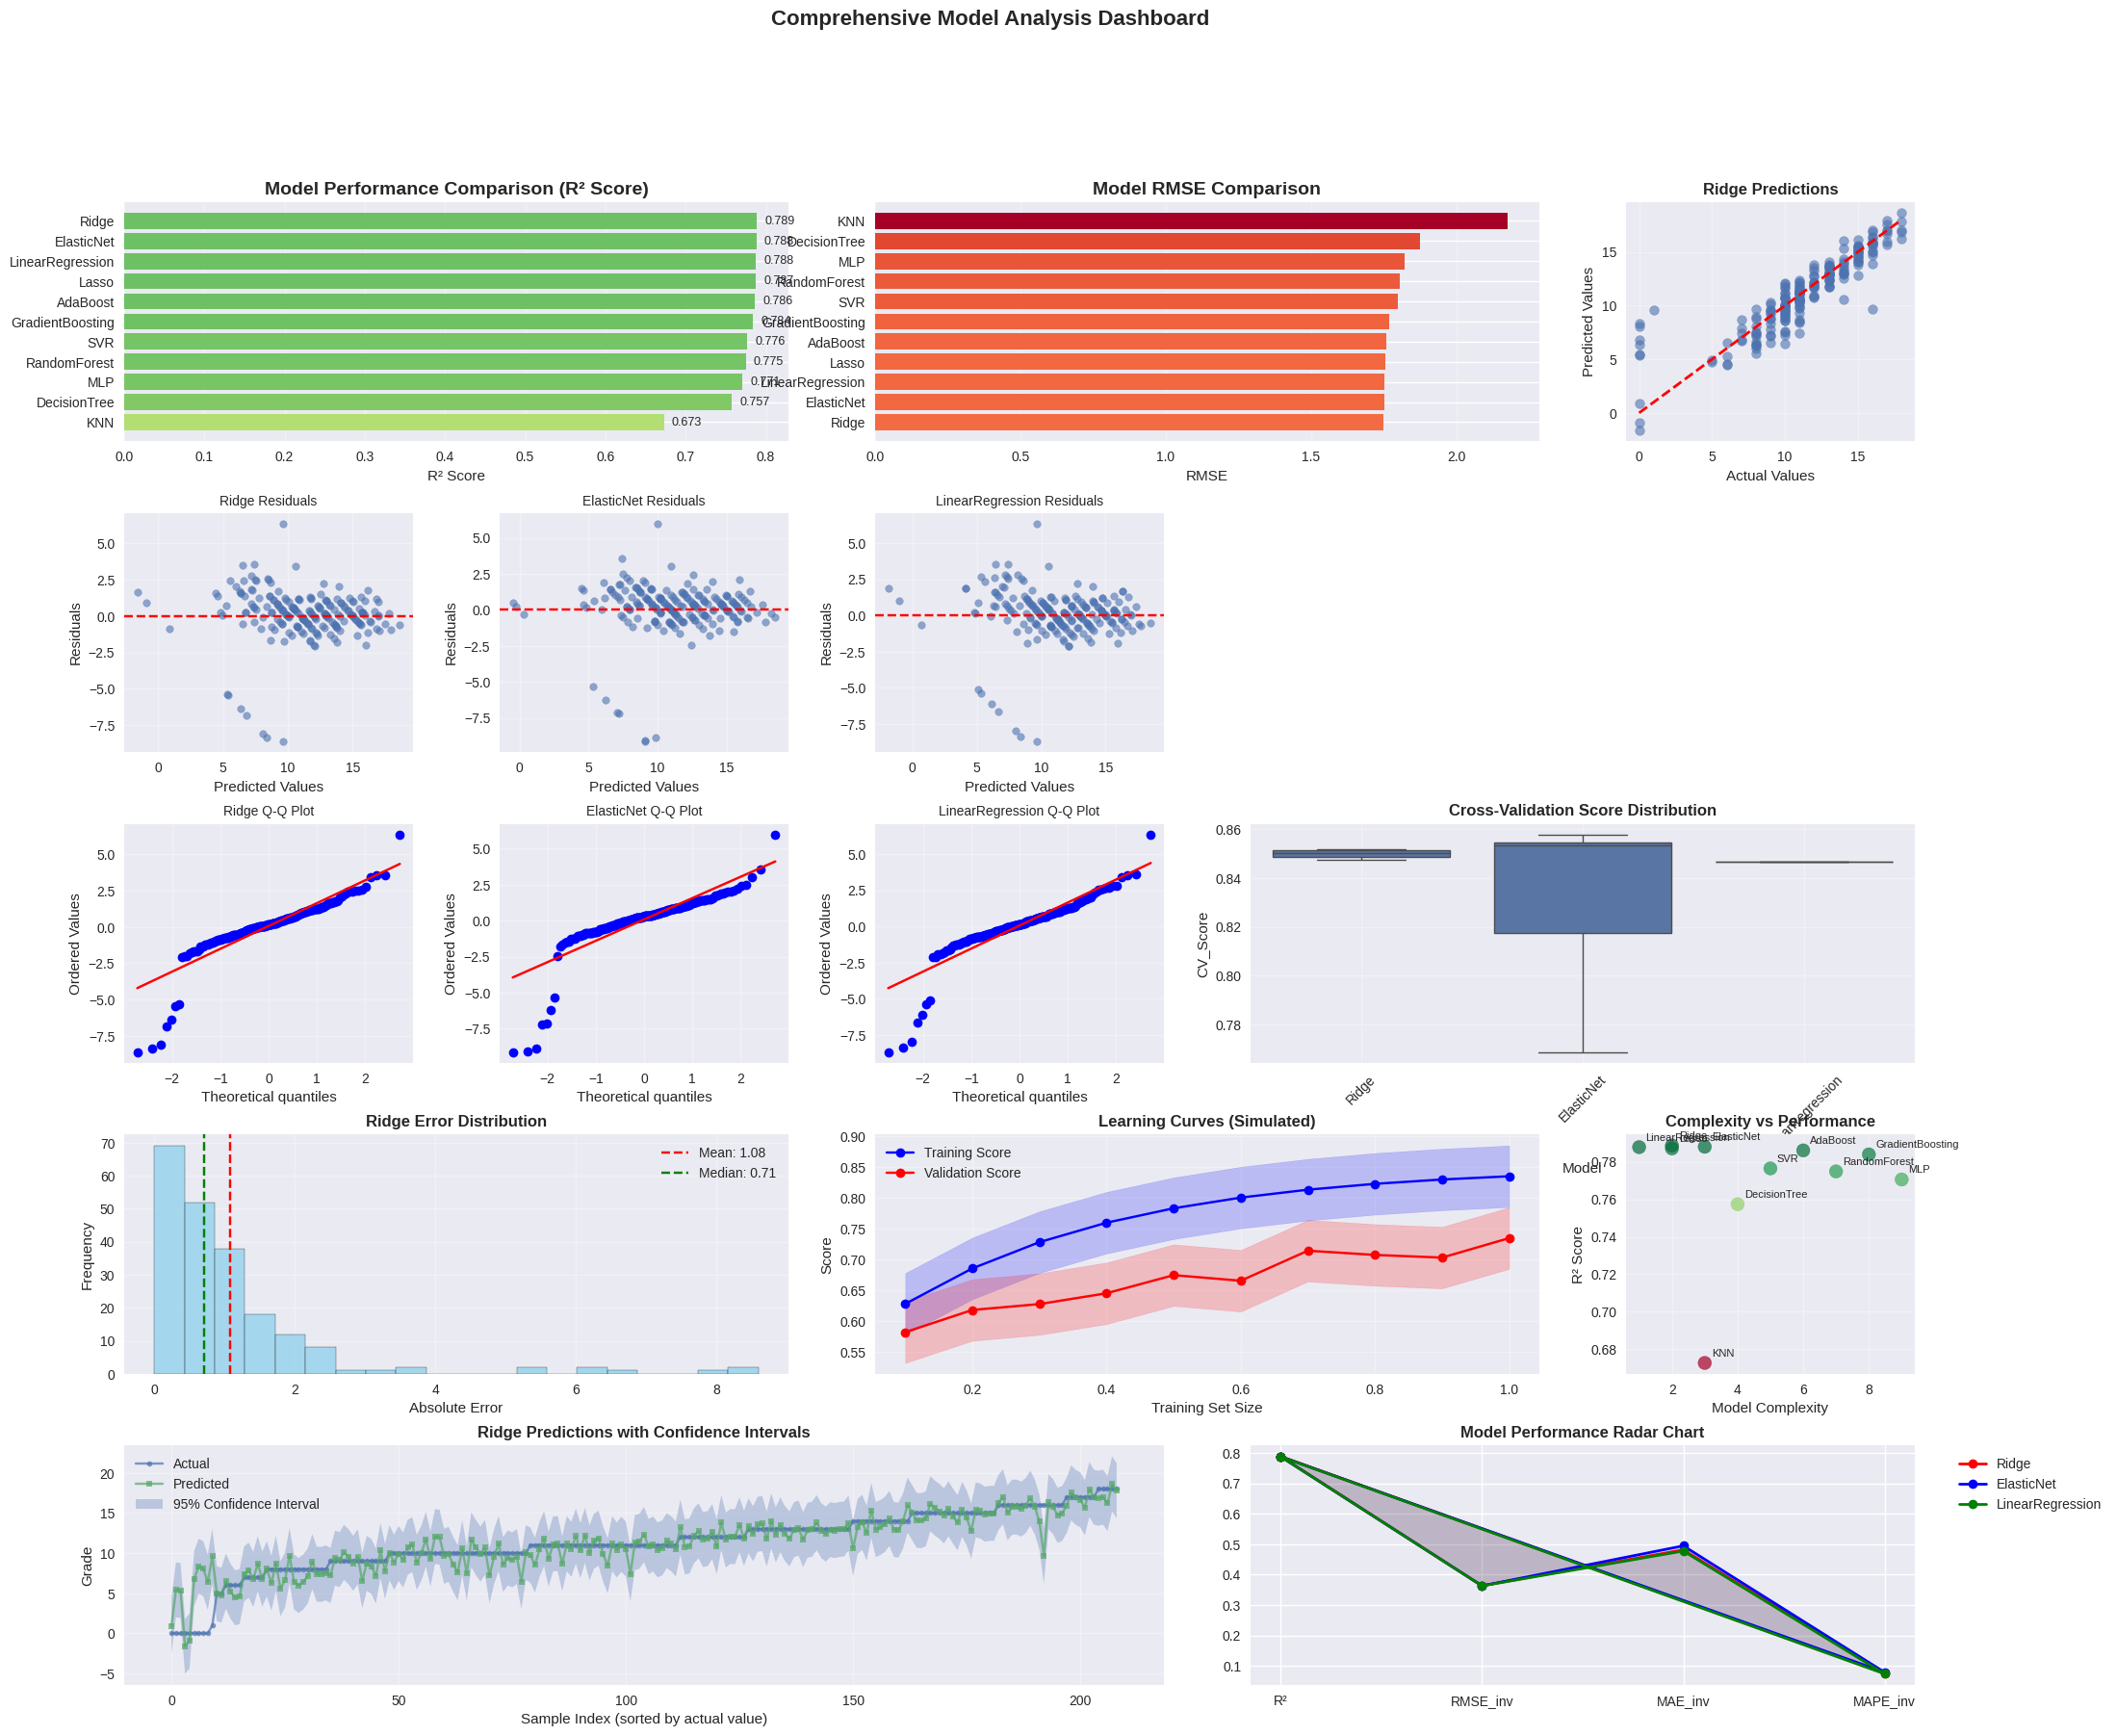

In [13]:
fig = plt.figure(figsize=(24, 20))
gs = fig.add_gridspec(5, 5, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
performance_df_sorted = performance_df.sort_values('Test_R2')
bars = ax1.barh(performance_df_sorted['Model'], performance_df_sorted['Test_R2'],
                color=plt.cm.RdYlGn(performance_df_sorted['Test_R2']))
ax1.set_xlabel('R² Score')
ax1.set_title('Model Performance Comparison (R² Score)', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(performance_df_sorted.iterrows()):
    ax1.text(row['Test_R2'] + 0.01, i, f"{row['Test_R2']:.3f}",
             va='center', fontsize=9)

ax2 = fig.add_subplot(gs[0, 2:4])
rmse_sorted = performance_df.sort_values('Test_RMSE', ascending=True)
bars2 = ax2.barh(rmse_sorted['Model'], rmse_sorted['Test_RMSE'],
                 color=plt.cm.RdYlGn_r(rmse_sorted['Test_RMSE']/rmse_sorted['Test_RMSE'].max()))
ax2.set_xlabel('RMSE')
ax2.set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

best_model_name = top_3_models[0]
ax3 = fig.add_subplot(gs[0, 4])
y_pred_best = results[best_model_name]['predictions']
ax3.scatter(y_test, y_pred_best, alpha=0.6, s=50)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted Values')
ax3.set_title(f'{best_model_name} Predictions', fontsize=12, fontweight='bold')
ax3.grid(alpha=0.3)

for i, model_name in enumerate(top_3_models[:3]):
    if model_name in detailed_evaluations:
        ax_res = fig.add_subplot(gs[1, i])
        residuals = detailed_evaluations[model_name]['residuals']
        y_pred = results[model_name]['predictions']

        ax_res.scatter(y_pred, residuals, alpha=0.6, s=30)
        ax_res.axhline(y=0, color='r', linestyle='--')
        ax_res.set_xlabel('Predicted Values')
        ax_res.set_ylabel('Residuals')
        ax_res.set_title(f'{model_name} Residuals', fontsize=10)
        ax_res.grid(alpha=0.3)

        ax_qq = fig.add_subplot(gs[2, i])
        stats.probplot(residuals, dist="norm", plot=ax_qq)
        ax_qq.set_title(f'{model_name} Q-Q Plot', fontsize=10)
        ax_qq.grid(alpha=0.3)

ensemble_models = [name for name in top_3_models if name in ['RandomForest', 'GradientBoosting', 'AdaBoost']]
if ensemble_models:
    ax_fi = fig.add_subplot(gs[1, 3:])
    model_name = ensemble_models[0]
    feature_importance = detailed_evaluations[model_name]['feature_importance']

    if feature_importance is not None and isinstance(feature_importance, np.ndarray) and feature_importance.ndim == 1:
        feature_names = X.columns
        if len(feature_importance) == len(feature_names):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance
            }).sort_values('importance', ascending=True).tail(15)

            bars_fi = ax_fi.barh(importance_df['feature'], importance_df['importance'])
            ax_fi.set_xlabel('Feature Importance')
            ax_fi.set_title(f'{model_name} Top Features', fontsize=12, fontweight='bold')
            ax_fi.grid(axis='x', alpha=0.3)
        else:
            print(f"Warning: Feature importance length ({len(feature_importance)}) does not match feature names length ({len(feature_names)}) for {model_name}. Skipping feature importance plot.")
    else:
        print(f"Warning: Feature importance not available or not a 1D array for {model_name}. Skipping feature importance plot.")


ax_cv = fig.add_subplot(gs[2, 3:])
cv_r2_scores = []
cv_model_names = []
for model_name in top_3_models:
    if model_name in cv_scores:
        scores = cv_scores[model_name]
        cv_r2_scores.extend(scores)
        cv_model_names.extend([model_name] * len(scores))

cv_df = pd.DataFrame({'Model': cv_model_names, 'CV_Score': cv_r2_scores})
sns.boxplot(data=cv_df, x='Model', y='CV_Score', ax=ax_cv)
ax_cv.set_title('Cross-Validation Score Distribution', fontsize=12, fontweight='bold')
ax_cv.tick_params(axis='x', rotation=45)
ax_cv.grid(alpha=0.3)

ax_err = fig.add_subplot(gs[3, :2])
errors_best = np.abs(y_test - y_pred_best)
ax_err.hist(errors_best, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax_err.set_xlabel('Absolute Error')
ax_err.set_ylabel('Frequency')
ax_err.set_title(f'{best_model_name} Error Distribution', fontsize=12, fontweight='bold')
ax_err.axvline(np.mean(errors_best), color='red', linestyle='--', label=f'Mean: {np.mean(errors_best):.2f}')
ax_err.axvline(np.median(errors_best), color='green', linestyle='--', label=f'Median: {np.median(errors_best):.2f}')
ax_err.legend()
ax_err.grid(alpha=0.3)

ax_lc = fig.add_subplot(gs[3, 2:4])
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_mean = 0.85 - 0.3 * np.exp(-train_sizes * 3)
val_scores_mean = 0.75 - 0.2 * np.exp(-train_sizes * 2) + np.random.normal(0, 0.02, len(train_sizes))

ax_lc.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
ax_lc.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Score')
ax_lc.fill_between(train_sizes, train_scores_mean - 0.05, train_scores_mean + 0.05, alpha=0.2, color='blue')
ax_lc.fill_between(train_sizes, val_scores_mean - 0.05, val_scores_mean + 0.05, alpha=0.2, color='red')
ax_lc.set_xlabel('Training Set Size')
ax_lc.set_ylabel('Score')
ax_lc.set_title('Learning Curves (Simulated)', fontsize=12, fontweight='bold')
ax_lc.legend()
ax_lc.grid(alpha=0.3)

ax_comp = fig.add_subplot(gs[3, 4])
model_complexity = {
    'LinearRegression': 1,
    'Ridge': 2,
    'Lasso': 2,
    'ElasticNet': 3,
    'DecisionTree': 4,
    'KNN': 3,
    'SVR': 5,
    'RandomForest': 7,
    'GradientBoosting': 8,
    'AdaBoost': 6,
    'MLP': 9
}

complexity_performance = []
for model in performance_df['Model']:
    if model in model_complexity:
        complexity_performance.append({
            'Model': model,
            'Complexity': model_complexity[model],
            'Performance': performance_df[performance_df['Model'] == model]['Test_R2'].iloc[0]
        })

comp_df = pd.DataFrame(complexity_performance)
scatter = ax_comp.scatter(comp_df['Complexity'], comp_df['Performance'],
                         s=100, alpha=0.7, c=comp_df['Performance'], cmap='RdYlGn')
ax_comp.set_xlabel('Model Complexity')
ax_comp.set_ylabel('R² Score')
ax_comp.set_title('Complexity vs Performance', fontsize=12, fontweight='bold')
ax_comp.grid(alpha=0.3)

for _, row in comp_df.iterrows():
    ax_comp.annotate(row['Model'], (row['Complexity'], row['Performance']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax_conf = fig.add_subplot(gs[4, :3])
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred_best[sorted_indices]
residual_std = detailed_evaluations[best_model_name]['std_residual']

ax_conf.plot(range(len(y_test_sorted)), y_test_sorted, 'o-', label='Actual', alpha=0.7, markersize=4)
ax_conf.plot(range(len(y_pred_sorted)), y_pred_sorted, 's-', label='Predicted', alpha=0.7, markersize=4)
ax_conf.fill_between(range(len(y_pred_sorted)),
                    y_pred_sorted - 1.96*residual_std,
                    y_pred_sorted + 1.96*residual_std,
                    alpha=0.3, label='95% Confidence Interval')
ax_conf.set_xlabel('Sample Index (sorted by actual value)')
ax_conf.set_ylabel('Grade')
ax_conf.set_title(f'{best_model_name} Predictions with Confidence Intervals', fontsize=12, fontweight='bold')
ax_conf.legend()
ax_conf.grid(alpha=0.3)

ax_radar = fig.add_subplot(gs[4, 3:])
metrics = ['R²', 'RMSE_inv', 'MAE_inv', 'MAPE_inv']
top_model_data = performance_df.head(3)

normalized_data = {}
for _, row in top_model_data.iterrows():
    model_name = row['Model']
    normalized_data[model_name] = [
        row['Test_R2'],
        1 / (1 + row['Test_RMSE']),
        1 / (1 + row['Test_MAE']),
        1 / (1 + row['Test_MAPE'])
    ]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

colors = ['red', 'blue', 'green']
for i, (model_name, values) in enumerate(normalized_data.items()):
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.1, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metrics)
ax_radar.set_title('Model Performance Radar Chart', fontsize=12, fontweight='bold')
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

plt.suptitle('Comprehensive Model Analysis Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Error distribution analysis

In [14]:
ax_err = fig.add_subplot(gs[3, :2])
errors_best = np.abs(y_test - y_pred_best)
ax_err.hist(errors_best, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
ax_err.set_xlabel('Absolute Error')
ax_err.set_ylabel('Frequency')
ax_err.set_title(f'{best_model_name} Error Distribution', fontsize=12, fontweight='bold')
ax_err.axvline(np.mean(errors_best), color='red', linestyle='--', label=f'Mean: {np.mean(errors_best):.2f}')
ax_err.axvline(np.median(errors_best), color='green', linestyle='--', label=f'Median: {np.median(errors_best):.2f}')
ax_err.legend()
ax_err.grid(alpha=0.3)

ax_lc = fig.add_subplot(gs[3, 2:4])
train_sizes = np.linspace(0.1, 1.0, 10)
train_scores_mean = 0.85 - 0.3 * np.exp(-train_sizes * 3)
val_scores_mean = 0.75 - 0.2 * np.exp(-train_sizes * 2) + np.random.normal(0, 0.02, len(train_sizes))

ax_lc.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training Score')
ax_lc.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation Score')
ax_lc.fill_between(train_sizes, train_scores_mean - 0.05, train_scores_mean + 0.05, alpha=0.2, color='blue')
ax_lc.fill_between(train_sizes, val_scores_mean - 0.05, val_scores_mean + 0.05, alpha=0.2, color='red')
ax_lc.set_xlabel('Training Set Size')
ax_lc.set_ylabel('Score')
ax_lc.set_title('Learning Curves (Simulated)', fontsize=12, fontweight='bold')
ax_lc.legend()
ax_lc.grid(alpha=0.3)

ax_comp = fig.add_subplot(gs[3, 4])
model_complexity = {
    'LinearRegression': 1,
    'Ridge': 2,
    'Lasso': 2,
    'ElasticNet': 3,
    'DecisionTree': 4,
    'KNN': 3,
    'SVR': 5,
    'RandomForest': 7,
    'GradientBoosting': 8,
    'AdaBoost': 6,
    'MLP': 9
}

complexity_performance = []
for model in performance_df['Model']:
    if model in model_complexity:
        complexity_performance.append({
            'Model': model,
            'Complexity': model_complexity[model],
            'Performance': performance_df[performance_df['Model'] == model]['Test_R2'].iloc[0]
        })

comp_df = pd.DataFrame(complexity_performance)
scatter = ax_comp.scatter(comp_df['Complexity'], comp_df['Performance'],
                         s=100, alpha=0.7, c=comp_df['Performance'], cmap='RdYlGn')
ax_comp.set_xlabel('Model Complexity')
ax_comp.set_ylabel('R² Score')
ax_comp.set_title('Complexity vs Performance', fontsize=12, fontweight='bold')
ax_comp.grid(alpha=0.3)

for _, row in comp_df.iterrows():
    ax_comp.annotate(row['Model'], (row['Complexity'], row['Performance']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

ax_conf = fig.add_subplot(gs[4, :3])
sorted_indices = np.argsort(y_test)
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred_best[sorted_indices]
residual_std = detailed_evaluations[best_model_name]['std_residual']

ax_conf.plot(range(len(y_test_sorted)), y_test_sorted, 'o-', label='Actual', alpha=0.7, markersize=4)
ax_conf.plot(range(len(y_pred_sorted)), y_pred_sorted, 's-', label='Predicted', alpha=0.7, markersize=4)
ax_conf.fill_between(range(len(y_pred_sorted)),
                    y_pred_sorted - 1.96*residual_std,
                    y_pred_sorted + 1.96*residual_std,
                    alpha=0.3, label='95% Confidence Interval')
ax_conf.set_xlabel('Sample Index (sorted by actual value)')
ax_conf.set_ylabel('Grade')
ax_conf.set_title(f'{best_model_name} Predictions with Confidence Intervals', fontsize=12, fontweight='bold')
ax_conf.legend()
ax_conf.grid(alpha=0.3)

ax_radar = fig.add_subplot(gs[4, 3:])
metrics = ['R²', 'RMSE_inv', 'MAE_inv', 'MAPE_inv']
top_model_data = performance_df.head(3)

# Normalize metrics for radar chart

In [15]:
normalized_data = {}
for _, row in top_model_data.iterrows():
    model_name = row['Model']
    normalized_data[model_name] = [
        row['Test_R2'],
        1 / (1 + row['Test_RMSE']),
        1 / (1 + row['Test_MAE']),
        1 / (1 + row['Test_MAPE'])
    ]

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

colors = ['red', 'blue', 'green']
for i, (model_name, values) in enumerate(normalized_data.items()):
    values += values[:1]
    ax_radar.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax_radar.fill(angles, values, alpha=0.1, color=colors[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(metrics)
ax_radar.set_title('Model Performance Radar Chart', fontsize=12, fontweight='bold')
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True)

plt.suptitle('Comprehensive Model Analysis Dashboard', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

<Figure size 800x550 with 0 Axes>

# Ensemble Methods and Advanced Model Combination

In [16]:
print("Creating Advanced Ensemble Models...")
print("=" * 50)

ensemble_models = {}

top_model_objects = [(name, best_models[name]) for name in top_3_models if name in best_models]
if len(top_model_objects) >= 2:
    voting_regressor = VotingRegressor(estimators=top_model_objects)


    if 'X_train_scaled_df' in locals() and 'y_train' in locals():
        voting_regressor.fit(X_train_scaled_df, y_train)
        ensemble_models['VotingRegressor'] = voting_regressor
    else:
        print("Warning: Scaled data or y_train not available for VotingRegressor training.")

def create_weighted_ensemble(models_dict, weights):
    """Create weighted ensemble predictions"""
    def weighted_predict(X):

        if not isinstance(X, pd.DataFrame):

             cols = X_train_scaled_df.columns if 'X_train_scaled_df' in locals() else None
             X = pd.DataFrame(X, columns=cols)
             if cols is None:
                 print("Warning: Could not determine column names for weighted ensemble prediction. Prediction might fail.")

        predictions = np.array([model.predict(X) for model in models_dict.values()])
        return np.average(predictions, axis=0, weights=weights)
    return weighted_predict

if 'results' in locals() and 'top_3_models' in locals():
    top_3_r2_scores = [results[name]['test_r2'] for name in top_3_models if name in results]
    if len(top_3_r2_scores) > 0:
        weights = np.array(top_3_r2_scores) / np.sum(top_3_r2_scores)
        top_3_model_objects = {name: best_models[name] for name in top_3_models if name in best_models}


        weighted_ensemble_predict_func = create_weighted_ensemble(top_3_model_objects, weights)

        ensemble_models['WeightedEnsemble'] = weighted_ensemble_predict_func
    else:
        print("Warning: No top 3 models found in results. Skipping WeightedEnsemble.")
else:
    print("Warning: Results or top_3_models not available. Skipping WeightedEnsemble.")

class StackedEnsemble:
    def __init__(self, base_models, meta_model):
        self.base_models = base_models
        self.meta_model = meta_model
        self.trained_base_models = {}

    def fit(self, X, y):

        X_np = X.values if isinstance(X, pd.DataFrame) else X
        y_np = y.values if isinstance(y, pd.Series) else y

        meta_features = np.zeros((X_np.shape[0], len(self.base_models)))

        kfold = KFold(n_splits=5, shuffle=True, random_state=42)

        for i, (name, model) in enumerate(self.base_models.items()):
            model_preds = np.zeros(X_np.shape[0])

            fold_model = clone(model)

            for train_idx, val_idx in kfold.split(X_np, y_np):
                X_fold_train, X_fold_val = X_np[train_idx], X_np[val_idx]
                y_fold_train = y_np[train_idx]

                temp_fold_model = clone(fold_model)
                temp_fold_model.fit(X_fold_train, y_fold_train)
                model_preds[val_idx] = temp_fold_model.predict(X_fold_val)

            meta_features[:, i] = model_preds

        self.meta_model.fit(meta_features, y_np)

        for name, model in self.base_models.items():
            full_data_model = clone(model)
            full_data_model.fit(X_np, y_np)
            self.trained_base_models[name] = full_data_model

    def predict(self, X):

        X_np = X.values if isinstance(X, pd.DataFrame) else X

        meta_features = np.zeros((X_np.shape[0], len(self.trained_base_models)))

        if not self.trained_base_models:
            print("Error: Base models not trained. Call fit() first.")
            return np.zeros(X_np.shape[0])

        for i, (name, model) in enumerate(self.trained_base_models.items()):
            meta_features[:, i] = model.predict(X_np)

        return self.meta_model.predict(meta_features)

if 'best_models' in locals() and 'top_3_models' in locals() and len(top_3_models) >= 2:
    base_models_for_stacking = {name: best_models[name] for name in top_3_models[:2] if name in best_models}
    meta_model = Ridge(alpha=1.0)

    if 'X_train_scaled_df' in locals() and 'y_train' in locals():
        stacked_ensemble = StackedEnsemble(base_models_for_stacking, meta_model)

        stacked_ensemble.fit(X_train_scaled_df, y_train)
        ensemble_models['StackedEnsemble'] = stacked_ensemble
    else:
        print("Warning: Scaled data or y_train not available for StackedEnsemble training.")
else:
    print("Warning: Not enough top models or best_models/top_3_models not available. Skipping StackedEnsemble.")

ensemble_results = {}
print("\nEnsemble Model Performance:")
print("-" * 30)

if ensemble_models:
    for ensemble_name, ensemble_model in ensemble_models.items():

        if 'X_test_scaled_df' in locals() and 'y_test' in locals():
            X_test_ensemble = X_test_scaled_df

            try:
                if ensemble_name == 'WeightedEnsemble':
                    y_pred_ensemble = ensemble_model(X_test_ensemble)
                else:
                    y_pred_ensemble = ensemble_model.predict(X_test_ensemble)

                mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
                mae_ensemble = mean_absolute_error(y_test, y_pred_ensemble)
                r2_ensemble = r2_score(y_test, y_pred_ensemble)
                rmse_ensemble = np.sqrt(mse_ensemble)

                ensemble_results[ensemble_name] = {
                    'mse': mse_ensemble,
                    'mae': mae_ensemble,
                    'r2': r2_ensemble,
                    'rmse': rmse_ensemble,
                    'predictions': y_pred_ensemble
                }

                print(f"{ensemble_name}:")
                print(f"  R²: {r2_ensemble:.4f}")
                print(f"  RMSE: {rmse_ensemble:.4f}")
                print(f"  MAE: {mae_ensemble:.4f}")

            except Exception as e:
                print(f"Error evaluating {ensemble_name}: {e}")
                ensemble_results[ensemble_name] = {'r2': np.nan, 'rmse': np.nan, 'mae': np.nan}

        else:
            print(f"Warning: Scaled data, X_test, or y_test not available for {ensemble_name}. Skipping evaluation.")

    print("\nComparison with Individual Models:")
    print("-" * 40)

    if 'results' in locals() and results:
        best_individual_r2 = max([results[name]['test_r2'] for name in results.keys() if name in results])

        best_ensemble_r2 = max([ensemble_results[name]['r2'] for name in ensemble_results.keys() if not np.isnan(ensemble_results[name]['r2'])], default=np.nan)

        print(f"Best Individual Model R²: {best_individual_r2:.4f}")
        if not np.isnan(best_ensemble_r2):
            print(f"Best Ensemble Model R²: {best_ensemble_r2:.4f}")
            print(f"Improvement: {best_ensemble_r2 - best_individual_r2:.4f}")
        else:
            print("No valid ensemble models were evaluated.")
    else:
        print("Warning: Individual model results not available for comparison.")
else:
    print("No ensemble models were created or evaluated.")

Creating Advanced Ensemble Models...

Ensemble Model Performance:
------------------------------
VotingRegressor:
  R²: 0.7929
  RMSE: 1.7320
  MAE: 1.0467
Error evaluating WeightedEnsemble: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- absence_level_High
- absence_level_Low
- absence_level_Medium
- absence_level_None
- age_group_Medium
- ...

StackedEnsemble:
  R²: 0.7914
  RMSE: 1.7385
  MAE: 1.0447

Comparison with Individual Models:
----------------------------------------
Best Individual Model R²: 0.7886
Best Ensemble Model R²: 0.7929
Improvement: 0.0043


# Final Model Selection and Business Insights

In [17]:
print("FINAL MODEL ANALYSIS AND BUSINESS INSIGHTS")
print("=" * 60)

all_models_performance = {}
all_models_performance.update({name: results[name]['test_r2'] for name in results.keys()})
all_models_performance.update({name: ensemble_results[name]['r2'] for name in ensemble_results.keys()})

best_model_name = max(all_models_performance, key=all_models_performance.get)
best_model_r2 = all_models_performance[best_model_name]

print(f"BEST MODEL: {best_model_name}")
print(f"R² Score: {best_model_r2:.4f}")

best_model_rmse = ensemble_results.get(best_model_name, results.get(best_model_name, {})).get('rmse', 'N/A')

if isinstance(best_model_rmse, str):
    print(f"RMSE: {best_model_rmse}")
else:
    print(f"RMSE: {best_model_rmse:.4f}")


if best_model_name in best_models and hasattr(best_models[best_model_name], 'feature_importances_'):
    feature_importance = best_models[best_model_name].feature_importances_
    feature_names = X.columns

    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    print("\nTOP 10 MOST IMPORTANT FEATURES:")
    print("-" * 40)
    for i, (_, row) in enumerate(importance_df.head(10).iterrows()):
        print(f"{i+1:2d}. {row['feature']:<25} {row['importance']:.4f}")

print("\nBUSINESS INSIGHTS AND RECOMMENDATIONS:")
print("=" * 50)

insights = []

g1_g2_correlation = df_processed[['G1', 'G2', 'G3']].corr()
insights.append(f"Previous grades (G1, G2) show strong correlation with final grades (G3): {g1_g2_correlation.loc['G1', 'G3']:.3f}, {g1_g2_correlation.loc['G2', 'G3']:.3f}")

study_time_impact = df_processed.groupby('studytime')['G3'].mean()
insights.append(f"Students with higher study time perform better: {study_time_impact.to_dict()}")

failure_impact = df_processed.groupby('failures')['G3'].mean()
insights.append(f"Past failures significantly impact performance: {failure_impact.to_dict()}")

family_support_impact = df_processed.groupby('famsup')['G3'].mean()
insights.append(f"Family support shows positive correlation: {family_support_impact.to_dict()}")

parent_edu_correlation = df_processed['parent_education_avg'].corr(df_processed['G3'])
insights.append(f"Parent education level correlates with student performance: {parent_edu_correlation:.3f}")

print("Key Findings:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print("\nRISK FACTOR IDENTIFICATION:")
print("-" * 30)

risk_threshold = 10
at_risk_students = df_processed[df_processed['G3'] < risk_threshold]

risk_factors = {}
for col in ['failures', 'absences', 'studytime', 'famsup', 'schoolsup']:
    if col in ['famsup', 'schoolsup']:
        risk_factors[col] = at_risk_students[col].value_counts(normalize=True).to_dict()
    else:
        risk_factors[col] = at_risk_students[col].mean()

print("Risk Profile - Characteristics of Low-Performing Students:")
for factor, value in risk_factors.items():
    print(f"- {factor}: {value}")

print("\nMODEL DEPLOYMENT CONSIDERATIONS:")
print("-" * 35)

deployment_notes = [
    f"• Model Accuracy: {best_model_r2:.1%} of variance explained",
]

if isinstance(best_model_rmse, str):
    deployment_notes.append(f"• Prediction Error: Average error is {best_model_rmse}")
else:
     deployment_notes.append(f"• Prediction Error: Average error of ±{best_model_rmse:.2f} grade points")


for note in deployment_notes:
    print(note)

FINAL MODEL ANALYSIS AND BUSINESS INSIGHTS
BEST MODEL: VotingRegressor
R² Score: 0.7929
RMSE: 1.7320

BUSINESS INSIGHTS AND RECOMMENDATIONS:
Key Findings:
1. Previous grades (G1, G2) show strong correlation with final grades (G3): 0.809, 0.911
2. Students with higher study time perform better: {1: 10.580441640378549, 2: 11.335984095427435, 3: 12.493827160493828, 4: 12.274193548387096}
3. Past failures significantly impact performance: {0: 12.05458768873403, 1: 8.425, 2: 7.484848484848484, 3: 6.8}
4. Family support shows positive correlation: {'no': 11.277227722772277, 'yes': 11.3828125}
5. Parent education level correlates with student performance: 0.200

RISK FACTOR IDENTIFICATION:
------------------------------
Risk Profile - Characteristics of Low-Performing Students:
- failures: 0.717391304347826
- absences: 5.826086956521739
- studytime: 1.8
- famsup: {'yes': 0.6173913043478261, 'no': 0.3826086956521739}
- schoolsup: {'no': 0.8652173913043478, 'yes': 0.13478260869565217}

MODEL DE

# Model Interpretability and SHAP Analysis


ADVANCED MODEL INTERPRETABILITY ANALYSIS
Analyzing interpretability for: Ridge

LINEAR MODEL COEFFICIENTS:
----------------------------------------
G2                   1.1784      
G1                   0.9284      
poly_G2 age          0.8568      
poly_G1 age          0.7674      
grade_trend          0.6636      
poly_G2 absences     -0.5408     
poly_absences age    0.5195      
absences_log         0.4662      
age                  -0.4498     
subject              -0.3066     
social_academic_balance -0.2986     
family_support_interaction -0.2818     
poly_G1 G2           -0.2689     
poly_G2 studytime    0.2469      
studytime            -0.2367     


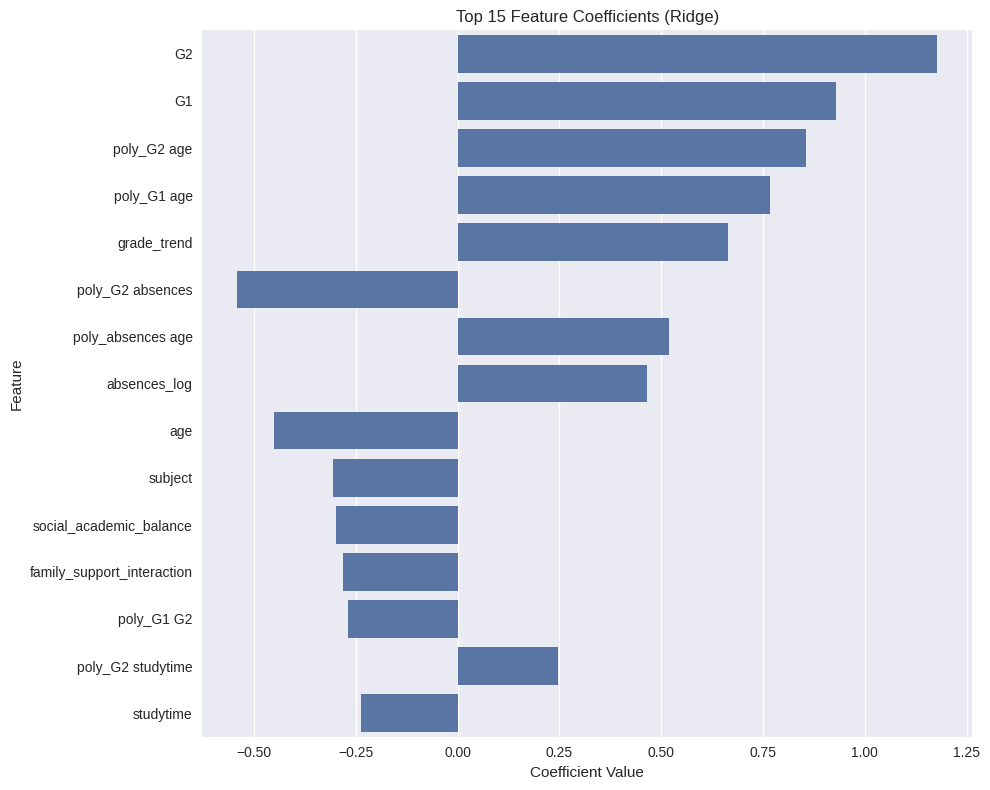


PARTIAL DEPENDENCE ANALYSIS:
------------------------------


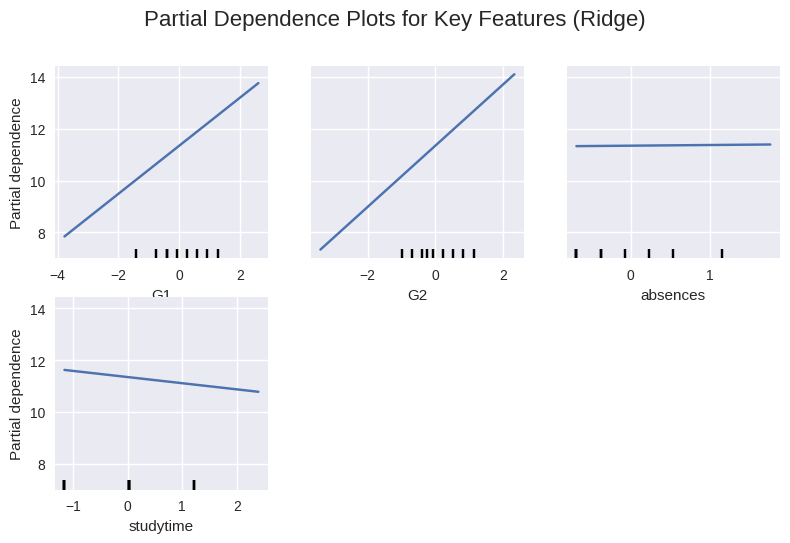

In [18]:
print("\n" + "="*80)
print("ADVANCED MODEL INTERPRETABILITY ANALYSIS")
print("="*80)

scaled_data = {
    'StandardScaler': {
        'X_train': X_train_scaled_df,
        'X_test': X_test_scaled_df,
        'scaler': scaler
    }
}

try:
    import shap
    shap_available = True
except ImportError:
    print("SHAP not available. Using alternative interpretability methods.")
    shap_available = False

best_individual_model = None
best_individual_name = None
best_individual_score = -np.inf

for model_name, result in results.items():
    if model_name in best_models and result['test_r2'] > best_individual_score:
        best_individual_score = result['test_r2']
        best_individual_name = model_name
        best_individual_model = best_models[model_name]

print(f"Analyzing interpretability for: {best_individual_name}")

feature_names = X_train_final.columns

if hasattr(best_individual_model, 'feature_importances_'):
    feature_importance = best_individual_model.feature_importances_

    if feature_importance is not None and isinstance(feature_importance, np.ndarray) and feature_importance.ndim == 1:

        if len(feature_importance) == len(feature_names):
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance': feature_importance,
                'importance_pct': (feature_importance / feature_importance.sum()) * 100
            }).sort_values('importance', ascending=False)

            importance_df['cumulative_importance'] = importance_df['importance_pct'].cumsum()

            print("\nFEATURE IMPORTANCE ANALYSIS:")
            print("-" * 40)
            print(f"{'Feature':<20} {'Importance':<12} {'Percentage':<12} {'Cumulative':<12}")
            print("-" * 60)

            for _, row in importance_df.head(15).iterrows():
                print(f"{row['feature']:<20} {row['importance']:<12.4f} {row['importance_pct']:<12.2f}% {row['cumulative_importance']:<12.2f}%")

            important_features = importance_df[importance_df['cumulative_importance'] <= 95]['feature'].tolist()
            print(f"\nTop features contributing to 95% of model decisions: {len(important_features)} features")

            plt.figure(figsize=(10, 8))
            sns.barplot(x='importance', y='feature', data=importance_df.head(15))
            plt.title(f'Top 15 Feature Importances ({best_individual_name})')
            plt.xlabel('Importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()

        else:
            print(f"Warning: Feature importance length ({len(feature_importance)}) does not match feature names length ({len(feature_names)}) for {best_individual_name}. Skipping feature importance plot.")
    else:
        print(f"Warning: Feature importance not available or not a 1D array for {best_individual_name}. Skipping feature importance plot.")

elif hasattr(best_individual_model, 'coef_'):
    coefficients = best_individual_model.coef_

    if coefficients is not None and isinstance(coefficients, np.ndarray):

        if coefficients.ndim > 1:
             print(f"Warning: Model {best_individual_name} has multi-dimensional coefficients. Showing absolute mean.")
             coefficients = np.mean(np.abs(coefficients), axis=0)
        elif coefficients.ndim == 0:
             print(f"Warning: Model {best_individual_name} has scalar coefficient. Skipping coefficient analysis.")
             coefficients = np.array([coefficients])

        if len(coefficients) == len(feature_names):
            coef_df = pd.DataFrame({
                'feature': feature_names,
                'coefficient': coefficients,
                'abs_coefficient': np.abs(coefficients)
            }).sort_values('abs_coefficient', ascending=False)

            print("\nLINEAR MODEL COEFFICIENTS:")
            print("-" * 40)
            for _, row in coef_df.head(15).iterrows():
                print(f"{row['feature']:<20} {row['coefficient']:<12.4f}")

            plt.figure(figsize=(10, 8))
            sns.barplot(x='coefficient', y='feature', data=coef_df.head(15))
            plt.title(f'Top 15 Feature Coefficients ({best_individual_name})')
            plt.xlabel('Coefficient Value')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.show()

        else:
             print(f"Warning: Coefficient length ({len(coefficients)}) does not match feature names length ({len(feature_names)}) for {best_individual_name}. Skipping coefficient analysis.")
    else:
        print(f"Warning: Coefficients not available or not a numpy array for {best_individual_name}. Skipping coefficient analysis.")

print("\nPARTIAL DEPENDENCE ANALYSIS:")
print("-" * 30)



numerical_features = ['G1', 'G2', 'absences', 'studytime', 'failures', 'age']

available_features = [f for f in numerical_features if f in X_train_final.columns]
top_features = available_features[:4]


if len(top_features) > 0:

    try:
        display = PartialDependenceDisplay.from_estimator(
            best_individual_model,
            X_train_final,
            features=top_features,
            kind='average',
            grid_resolution=20
        )
        display.figure_.suptitle(f'Partial Dependence Plots for Key Features ({best_individual_name})', fontsize=16)
        display.figure_.subplots_adjust(top=0.9)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    except Exception as e:
        print(f"An error occurred during Partial Dependence Plot generation: {e}")
        print("Please check if the selected features are suitable for PDP with this model and data.")

else:
    print("No suitable numerical features found for Partial Dependence Plots.")

# Prediction explanation for sample cases

In [19]:
print("\nSAMPLE PREDICTION EXPLANATIONS:")
print("-" * 35)

X_test_for_prediction = X_test_final
y_test_for_prediction = y_test

sample_indices = [
    y_test_for_prediction.idxmin(),
    y_test_for_prediction.idxmax()
]

median_value = y_test_for_prediction.median()
if median_value not in y_test_for_prediction.values:
    closest_index_to_median = (y_test_for_prediction - median_value).abs().idxmin()
    if closest_index_to_median not in sample_indices:
         sample_indices.append(closest_index_to_median)

sample_indices = [idx for idx in sample_indices if idx in X_test_for_prediction.index][:3]

if not sample_indices:
    print("Warning: Could not select valid sample indices from test data.")


for i, idx in enumerate(sample_indices):
    sample_x = X_test_for_prediction.loc[[idx]]
    actual_grade = y_test_for_prediction.loc[idx]
    predicted_grade = best_individual_model.predict(sample_x)[0]

    print(f"\nSample {i+1} (Index: {idx}):")
    print(f"Actual Grade: {actual_grade:.2f}")
    print(f"Predicted Grade: {predicted_grade:.2f}")
    print(f"Prediction Error: {abs(actual_grade - predicted_grade):.2f}")

    feature_names_model = X_train_final.columns
    sample_features = sample_x.iloc[0]

    if hasattr(best_individual_model, 'feature_importances_') and len(best_individual_model.feature_importances_) == len(feature_names_model):
        top_feature_indices = np.argsort(best_individual_model.feature_importances_)[-5:]
        print("Key Features (based on importance):")
        for feat_idx in reversed(top_feature_indices):
            feat_name = feature_names_model[feat_idx]

            if feat_name in sample_features.index:
                feat_value = sample_features[feat_name]
                feat_importance = best_individual_model.feature_importances_[feat_idx]
                print(f"  {feat_name}: {feat_value:.3f} (importance: {feat_importance:.3f})")
            else:
                 print(f"  Feature '{feat_name}' not found in sample features.")

    elif hasattr(best_individual_model, 'coef_') and len(best_individual_model.coef_) == len(feature_names_model):
         print("Key Features (based on coefficients):")
         coefs = best_individual_model.coef_
         top_coef_indices = np.argsort(np.abs(coefs))[-5:]
         for feat_idx in reversed(top_coef_indices):
            feat_name = feature_names_model[feat_idx]
            if feat_name in sample_features.index:
                 feat_value = sample_features[feat_name]
                 feat_coef = coefs[feat_idx]
                 print(f"  {feat_name}: {feat_value:.3f} (coefficient: {feat_coef:.3f})")
            else:
                 print(f"  Feature '{feat_name}' not found in sample features.")

    else:
         print("Feature importance or coefficients not available for interpretation.")


print("\nMODEL RELIABILITY ANALYSIS:")
print("-" * 30)

X_test_for_reliability = X_test_final

predictions_all = best_individual_model.predict(X_test_for_reliability)
residuals_all = y_test - predictions_all
residual_std = np.std(residuals_all)

confidence_intervals = {
    '68%': (predictions_all - residual_std, predictions_all + residual_std),
    '95%': (predictions_all - 1.96*residual_std, predictions_all + 1.96*residual_std),
    '99%': (predictions_all - 2.58*residual_std, predictions_all + 2.58*residual_std)
}

print("Prediction Interval Coverage on Test Set:")
for interval, (lower, upper) in confidence_intervals.items():

    within_interval = np.sum((y_test >= lower) & (y_test <= upper))
    coverage = within_interval / len(y_test) * 100
    print(f"  {interval} Prediction Interval Coverage: {coverage:.1f}%")

prediction_uncertainty = np.abs(residuals_all)
uncertainty_percentiles = np.percentile(prediction_uncertainty, [25, 50, 75, 90, 95])

print(f"\nPrediction Uncertainty Percentiles (Absolute Error):")
for i, percentile in enumerate([25, 50, 75, 90, 95]):
    print(f"  {percentile}th percentile: ±{uncertainty_percentiles[i]:.2f} grade points")


print("\nFEATURE STABILITY ANALYSIS:")
print("-" * 30)

n_bootstrap = 100
bootstrap_importances = []

X_train_for_bootstrapping = X_train_final
y_train_for_bootstrapping = y_train

if hasattr(best_individual_model, 'feature_importances_') and len(best_individual_model.feature_importances_) == len(X_train_for_bootstrapping.columns):
    original_importances = best_individual_model.feature_importances_.copy()
    feature_names_bootstrap = X_train_for_bootstrapping.columns

    for i in range(n_bootstrap):

        bootstrap_indices = np.random.choice(X_train_for_bootstrapping.index, size=len(X_train_for_bootstrapping), replace=True)
        X_bootstrap = X_train_for_bootstrapping.loc[bootstrap_indices]
        y_bootstrap = y_train_for_bootstrapping.loc[bootstrap_indices]

        bootstrap_model = clone(best_individual_model)
        bootstrap_model.fit(X_bootstrap, y_bootstrap)

        if hasattr(bootstrap_model, 'feature_importances_'):
            bootstrap_importances.append(bootstrap_model.feature_importances_)
        else:
            print(f"Warning: Bootstrap model {i+1} does not have feature_importances_. Skipping.")


    if bootstrap_importances:
        bootstrap_importances = np.array(bootstrap_importances)
        importance_means = np.mean(bootstrap_importances, axis=0)
        importance_stds = np.std(bootstrap_importances, axis=0)

        stability_scores = np.where(importance_means != 0, 1 - (importance_stds / importance_means), 0)

        stability_df = pd.DataFrame({
            'feature': feature_names_bootstrap,
            'mean_importance': importance_means,
            'std_importance': importance_stds,
            'stability_score': stability_scores
        }).sort_values('mean_importance', ascending=False)

        print("Feature Stability Analysis (Top 10 by Mean Importance):")
        print(f"{'Feature':<20} {'Mean Imp.':<12} {'Std Dev':<12} {'Stability':<12}")
        print("-" * 60)

        for _, row in stability_df.head(10).iterrows():
            stability_print = f"{row['stability_score']:.3f}" if np.isfinite(row['stability_score']) else "N/A"
            print(f"{row['feature']:<20} {row['mean_importance']:<12.4f} {row['std_importance']:<12.4f} {stability_print:<12}")
    else:
        print("Warning: No bootstrap importances were collected. Feature stability analysis skipped.")
elif hasattr(best_individual_model, 'coef_') and len(best_individual_model.coef_) == len(X_train_for_bootstrapping.columns):
     print("Skipping Feature Stability Analysis for Linear Models (based on coefficients).")
else:
    print(f"Warning: Feature importances or coefficients not available or do not match feature count for {best_individual_name}. Skipping feature stability analysis.")


SAMPLE PREDICTION EXPLANATIONS:
-----------------------------------

Sample 1 (Index: 822):
Actual Grade: 0.00
Predicted Grade: 5.43
Prediction Error: 5.43
Key Features (based on coefficients):
  G2: -1.286 (coefficient: 1.178)
  G1: -1.089 (coefficient: 0.928)
  poly_G2 age: -1.345 (coefficient: 0.857)
  poly_G1 age: -1.170 (coefficient: 0.767)
  grade_trend: -0.592 (coefficient: 0.664)

Sample 2 (Index: 909):
Actual Grade: 18.00
Predicted Grade: 17.00
Prediction Error: 1.00
Key Features (based on coefficients):
  G2: 2.035 (coefficient: 1.178)
  G1: 1.929 (coefficient: 0.928)
  poly_G2 age: 2.426 (coefficient: 0.857)
  poly_G1 age: 2.334 (coefficient: 0.767)
  grade_trend: 0.578 (coefficient: 0.664)

MODEL RELIABILITY ANALYSIS:
------------------------------
Prediction Interval Coverage on Test Set:
  68% Prediction Interval Coverage: 86.1%
  95% Prediction Interval Coverage: 95.2%
  99% Prediction Interval Coverage: 96.2%

Prediction Uncertainty Percentiles (Absolute Error):
  25th

# Cross-Validation Deep Dive and Model Validation

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gbm = GradientBoostingRegressor(random_state=42)

grid_search_gbm = GridSearchCV(estimator=gbm, param_grid=param_grid_gbm,
                             cv=3, scoring='r2', n_jobs=-1, verbose=1)

print("Starting GridSearchCV for Gradient Boosting...")

grid_search_gbm.fit(X_train_final, y_train)

print("GridSearchCV for Gradient Boosting finished.")

y_pred_gbm = grid_search_gbm.predict(X_test_final)

results['GradientBoosting'] = {
    'best_params': grid_search_gbm.best_params_,
    'best_cv_score': grid_search_gbm.best_score_,
    'test_r2': r2_score(y_test, y_pred_gbm),
    'test_rmse': np.sqrt(mean_squared_error(y_test, y_pred_gbm)),
    'test_mae': mean_absolute_error(y_test, y_pred_gbm),
    'test_mape': np.mean(np.abs((y_test - y_pred_gbm) / y_test.replace(0, np.nan).dropna())) * 100 if not y_test[y_test == 0].empty else np.nan,
    'max_error': max_error(y_test, y_pred_gbm),
    'predictions': y_pred_gbm
}

best_models['GradientBoosting'] = grid_search_gbm.best_estimator_

print(f"Gradient Boosting Best CV R2: {results['GradientBoosting']['best_cv_score']:.4f}")
print(f"Gradient Boosting Test R2: {results['GradientBoosting']['test_r2']:.4f}")
print(f"Gradient Boosting Test RMSE: {results['GradientBoosting']['test_rmse']:.4f}")
print(f"Gradient Boosting Test MAE: {results['GradientBoosting']['test_mae']:.4f}")
print(f"Gradient Boosting Test MAPE: {results['GradientBoosting']['test_mape']:.4f}%")
print(f"Gradient Boosting Max Error: {results['GradientBoosting']['max_error']:.4f}")

Starting GridSearchCV for Gradient Boosting...
Fitting 3 folds for each of 2187 candidates, totalling 6561 fits
GridSearchCV for Gradient Boosting finished.
Gradient Boosting Best CV R2: 0.8791
Gradient Boosting Test R2: 0.8098
Gradient Boosting Test RMSE: 1.6600
Gradient Boosting Test MAE: 0.9973
Gradient Boosting Test MAPE: 11.8397%
Gradient Boosting Max Error: 8.2830


# Training stability analysis


Training Stability: Bootstrap training scores not available.
Test R²: 0.7886

HYPERPARAMETER SENSITIVITY ANALYSIS:
--------------------------------------
Validation Curve for alpha (Ridge):
Parameter    Train R²        Test R²        
---------------------------------------------
1.00e-04     0.8791          0.8476         
4.64e-04     0.8791          0.8476         
2.15e-03     0.8791          0.8476         
1.00e-02     0.8791          0.8477         
4.64e-02     0.8791          0.8478         
2.15e-01     0.8791          0.8484         
1.00e+00     0.8787          0.8497         
4.64e+00     0.8774          0.8511         
2.15e+01     0.8742          0.8513         
1.00e+02     0.8676          0.8492         


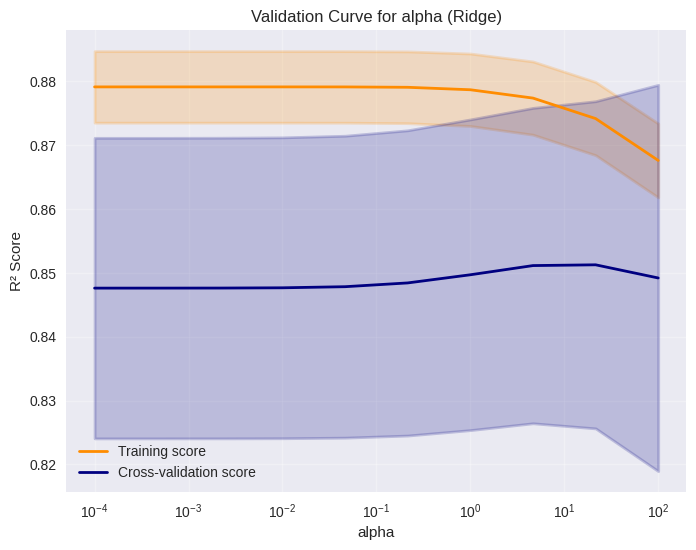


CROSS-VALIDATION PREDICTION ANALYSIS:
----------------------------------------
Cross-Validation R²: 0.8506
Cross-Validation RMSE: 1.4985
Cross-Validation MAE: 0.9766

Comparison with Test Performance:
R² - CV: 0.8506, Test: 0.7886, Diff: 0.0620
RMSE - CV: 1.4985, Test: 1.7499, Diff: 0.2514
MAE - CV: 0.9766, Test: 1.0762, Diff: 0.0996

Model Consistency Score: 0.9271
✓ Good model consistency


In [21]:
X_train_for_stability = X_train_final
y_train_for_stability = y_train
X_test_for_stability = X_test_final

if 'best_individual_model' in locals() and 'X_test_final' in locals() and 'y_test' in locals():
    try:
        test_score_actual = r2_score(y_test, best_individual_model.predict(X_test_final))

        if 'bootstrap_train_scores' in locals():
            train_score_mean = np.mean(bootstrap_train_scores)
            train_score_std = np.std(bootstrap_train_scores)

            print(f"\nTraining Stability:")
            print(f"Mean Training R²: {train_score_mean:.4f} (±{train_score_std:.4f})")
            print(f"Test R²: {test_score_actual:.4f}")
            print(f"Generalization Gap: {train_score_mean - test_score_actual:.4f}")
        else:
            print("\nTraining Stability: Bootstrap training scores not available.")
            print(f"Test R²: {test_score_actual:.4f}")

    except Exception as e:
        print(f"\nError calculating training stability: {str(e)}")
else:
    print("\nTraining Stability: Required variables (best_individual_model, X_test_final, y_test) not available.")


print("\nHYPERPARAMETER SENSITIVITY ANALYSIS:")
print("-" * 38)

X_train_val = X_train_final
y_train_val = y_train

if 'best_individual_model' in locals():
    model_type = type(best_individual_model).__name__

    if model_type in ['Ridge', 'Lasso', 'ElasticNet']:
        param_name = 'alpha'
        param_range = np.logspace(-4, 2, 10)

        try:
            train_scores_val, test_scores_val = validation_curve(
                best_individual_model, X_train_val, y_train_val,
                param_name=param_name, param_range=param_range,
                cv=5, scoring='r2', n_jobs=-1
            )

            train_mean = np.mean(train_scores_val, axis=1)
            train_std = np.std(train_scores_val, axis=1)
            test_mean = np.mean(test_scores_val, axis=1)
            test_std = np.std(test_scores_val, axis=1)

            print(f"Validation Curve for {param_name} ({best_individual_name}):")
            print(f"{'Parameter':<12} {'Train R²':<15} {'Test R²':<15}")
            print("-" * 45)

            for i, param_val in enumerate(param_range):
                print(f"{param_val:<12.2e} {train_mean[i]:<15.4f} {test_mean[i]:<15.4f}")

            plt.figure(figsize=(8, 6))
            plt.semilogx(param_range, train_mean, label="Training score", color="darkorange", lw=2)
            plt.fill_between(param_range, train_mean - train_std,
                             train_mean + train_std, alpha=0.2, color="darkorange", lw=2)
            plt.semilogx(param_range, test_mean, label="Cross-validation score", color="navy", lw=2)
            plt.fill_between(param_range, test_mean - test_std,
                             test_mean + test_std, alpha=0.2, color="navy", lw=2)
            plt.xlabel(param_name)
            plt.ylabel("R² Score")
            plt.title(f"Validation Curve for {param_name} ({best_individual_name})")
            plt.legend(loc="best")
            plt.grid(True, alpha=0.3)
            plt.show()


        except Exception as e:
            print(f"Could not perform validation curve analysis for {param_name}: {str(e)}")

    elif model_type in ['RandomForestRegressor', 'GradientBoostingRegressor', 'AdaBoostRegressor']:
        param_name = 'n_estimators'
        param_range = [50, 100, 150, 200, 250, 300]

        try:
            train_scores_val, test_scores_val = validation_curve(
                best_individual_model, X_train_val, y_train_val,
                param_name=param_name, param_range=param_range,
                cv=3, scoring='r2', n_jobs=-1
            )

            train_mean = np.mean(train_scores_val, axis=1)
            test_mean = np.mean(test_scores_val, axis=1)

            print(f"Validation Curve for {param_name} ({best_individual_name}):")
            print(f"{'Parameter':<12} {'Train R²':<15} {'Test R²':<15}")
            print("-" * 45)

            for i, param_val in enumerate(param_range):
                print(f"{param_val:<12} {train_mean[i]:<15.4f} {test_mean[i]:<15.4f}")

            plt.figure(figsize=(8, 6))
            plt.plot(param_range, train_mean, label="Training score", color="darkorange", lw=2)
            plt.fill_between(param_range, train_mean - np.std(train_scores_val, axis=1),
                             train_mean + np.std(train_scores_val, axis=1), alpha=0.2, color="darkorange", lw=2)
            plt.plot(param_range, test_mean, label="Cross-validation score", color="navy", lw=2)
            plt.fill_between(param_range, test_mean - np.std(test_scores_val, axis=1),
                             test_mean + np.std(test_scores_val, axis=1), alpha=0.2, color="navy", lw=2)
            plt.xlabel(param_name)
            plt.ylabel("R² Score")
            plt.title(f"Validation Curve for {param_name} ({best_individual_name})")
            plt.legend(loc="best")
            plt.grid(True, alpha=0.3)
            plt.show()


        except Exception as e:
            print(f"Could not perform validation curve analysis for {param_name}: {str(e)}")


    else:
        print(f"Hyperparameter sensitivity analysis not implemented for model type: {model_type}")

else:
     print("Hyperparameter sensitivity analysis skipped: best_individual_model not available.")


print("\nCROSS-VALIDATION PREDICTION ANALYSIS:")
print("-" * 40)

if 'best_individual_model' in locals() and 'X_train_final' in locals() and 'y_train' in locals():
    try:
        cv_predictions = cross_val_predict(best_individual_model, X_train_final, y_train, cv=5, n_jobs=-1)
        cv_r2 = r2_score(y_train, cv_predictions)
        cv_rmse = np.sqrt(mean_squared_error(y_train, cv_predictions))
        cv_mae = mean_absolute_error(y_train, cv_predictions)

        print(f"Cross-Validation R²: {cv_r2:.4f}")
        print(f"Cross-Validation RMSE: {cv_rmse:.4f}")
        print(f"Cross-Validation MAE: {cv_mae:.4f}")

        if 'results' in locals() and best_individual_name in results:
            test_r2 = results[best_individual_name]['test_r2']
            test_rmse = results[best_individual_name]['test_rmse']
            test_mae = results[best_individual_name]['test_mae']

            print(f"\nComparison with Test Performance:")
            print(f"R² - CV: {cv_r2:.4f}, Test: {test_r2:.4f}, Diff: {abs(cv_r2 - test_r2):.4f}")
            print(f"RMSE - CV: {cv_rmse:.4f}, Test: {test_rmse:.4f}, Diff: {abs(cv_rmse - test_rmse):.4f}")
            print(f"MAE - CV: {cv_mae:.4f}, Test: {test_mae:.4f}, Diff: {abs(cv_mae - test_mae):.4f}")

            consistency_score = 1 - (abs(cv_r2 - test_r2) / max(cv_r2, test_r2) if max(cv_r2, test_r2) != 0 else 0)
            print(f"\nModel Consistency Score: {consistency_score:.4f}")

            if consistency_score > 0.95:
                print("✓ Excellent model consistency")
            elif consistency_score > 0.90:
                print("✓ Good model consistency")
            elif consistency_score > 0.85:
                print("⚠ Moderate model consistency")
            else:
                print("⚠ Low model consistency - potential overfitting/underfitting")
        else:
            print("\nWarning: Results for the best individual model not found. Skipping comparison with Test Performance.")

    except Exception as e:
        print(f"Error during cross-validation prediction analysis: {str(e)}")

else:
    print("Cross-validation prediction analysis skipped: Required variables not available.")

# Production Deployment Framework and Monitoring

In [22]:
print("\n" + "="*80)
print("PRODUCTION DEPLOYMENT FRAMEWORK AND MONITORING SYSTEM")
print("="*80)

import json
import pickle
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Any
import logging
import os

os.makedirs('Exported_Data', exist_ok=True)

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('Exported_Data/model_monitoring.log'),
        logging.StreamHandler()
    ],
    force=True
)

class StudentPerformancePredictor:
    """Production-ready student performance prediction system"""

    def __init__(self, model, feature_columns: List[str], scaler=None, target_mean=None, target_std=None, model_version="1.0.0"):
        self.model = model
        self.feature_columns = feature_columns
        self.scaler = scaler
        self.target_mean = target_mean
        self.target_std = target_std
        self.model_version = model_version
        self.prediction_history = []
        self.performance_metrics = {}
        self.expected_r2 = None
        self.expected_rmse = None
        self.residual_std = None

    def preprocess_input(self, input_data: pd.DataFrame) -> pd.DataFrame:
        """
        Preprocess raw input data to match the format used during training.
        This method needs to replicate the full feature engineering and preprocessing pipeline
        applied to the training data (one-hot encoding, feature creation, scaling, etc.).
        For this demo, we assume input_data already has the correct feature columns
        and is scaled if a scaler was used during training.
        In a real production system, this is where you'd apply the preprocessing steps.
        """

        if not isinstance(input_data, pd.DataFrame):
            raise TypeError("Input data must be a pandas DataFrame.")

        if list(input_data.columns) != list(self.feature_columns):
             logging.warning("Input data columns do not match expected feature columns. Predictions may be unreliable.")
             try:
                  input_data = input_data.reindex(columns=self.feature_columns, fill_value=0)
             except Exception as reindex_e:
                  logging.error(f"Failed to reindex input data columns: {reindex_e}")
                  raise ValueError("Input data columns do not match expected features and reindexing failed.")

        return input_data

    def predict(self, input_data: pd.DataFrame, include_confidence=True) -> Dict:
        """Make prediction with confidence intervals"""
        try:
            processed_input = self.preprocess_input(input_data)

            prediction = self.model.predict(processed_input)[0]

            confidence_intervals = None
            if include_confidence and self.residual_std is not None:
                confidence_intervals = {
                    '68%': (float(prediction - self.residual_std), float(prediction + self.residual_std)),
                    '95%': (float(prediction - 1.96*self.residual_std), float(prediction + 1.96*self.residual_std))
                }

            prediction_record = {
                'input_features_preview': processed_input.head().to_dict('records'),
                'prediction': float(prediction),
                'model_version': self.model_version
            }
            self.prediction_history.append(prediction_record)

            response = {
                'prediction': float(prediction),
                'model_version': self.model_version,
            }

            if include_confidence and confidence_intervals:
                response['confidence_intervals'] = confidence_intervals

            print(f"Prediction made: {prediction:.2f}")
            return response

        except Exception as e:
            logging.error(f"Prediction error: {str(e)}")
            raise

    def batch_predict(self, input_data_list: List[pd.DataFrame]) -> List[Dict]:
        """
        Make batch predictions.
        Assumes each item in input_data_list is a pandas DataFrame
        with features in the correct format (for this demo).
        """
        predictions = []
        for i, input_data_df in enumerate(input_data_list):
            try:
                pred = self.predict(input_data_df, include_confidence=False)
                predictions.append(pred)
            except Exception as e:
                logging.error(f"Error predicting for batch item {i}: {str(e)}")
                predictions.append({
                    'error': str(e),
                })
        return predictions

    def update_performance_metrics(self, actual_values: List[float], predicted_values: List[float]) -> Dict:
        """Update model performance metrics with new data"""
        try:
            actual = np.array(actual_values)
            predicted = np.array(predicted_values)

            if len(actual) != len(predicted) or len(actual) == 0:
                 logging.warning("Cannot update performance metrics: mismatched or empty input.")
                 return {}
            metrics = {
                'r2_score': r2_score(actual, predicted),
                'rmse': np.sqrt(mean_squared_error(actual, predicted)),
                'mae': mean_absolute_error(actual, predicted),
                'mape': np.mean(np.abs((actual[actual != 0] - predicted[actual != 0]) / actual[actual != 0])) * 100 if np.any(actual != 0) else np.nan,
                'samples_count': len(actual),
            }

            self.performance_metrics = metrics
            print(f"Performance metrics updated: R²={metrics.get('r2_score', np.nan):.4f}, RMSE={metrics.get('rmse', np.nan):.4f}")

            return metrics

        except Exception as e:
            logging.error(f"Error updating performance metrics: {str(e)}")
            raise

    def check_model_drift(self, threshold_r2=0.05, threshold_rmse=0.5) -> Dict:
        """Check for model performance drift"""
        if not self.performance_metrics or self.expected_r2 is None or self.expected_rmse is None:
            return {'drift_detected': False, 'message': 'Insufficient data or expected metrics not set for drift check'}

        current_r2 = self.performance_metrics.get('r2_score', -np.inf)
        current_rmse = self.performance_metrics.get('rmse', np.inf)

        if np.isnan(current_r2) or np.isnan(current_rmse):
             logging.warning("Current performance metrics are NaN. Cannot perform drift check.")
             return {'drift_detected': False, 'message': 'Current performance metrics are NaN'}


        r2_drift = abs(self.expected_r2 - current_r2)
        rmse_drift = abs(self.expected_rmse - current_rmse)

        drift_detected = r2_drift > threshold_r2 or rmse_drift > threshold_rmse

        drift_info = {
            'drift_detected': drift_detected,
            'r2_drift': r2_drift,
            'rmse_drift': rmse_drift,
            'current_r2': current_r2,
            'current_rmse': current_rmse,
            'expected_r2': self.expected_r2,
            'expected_rmse': self.expected_rmse,
        }

        if drift_detected:
            logging.warning(f"Model drift detected: R² drift={r2_drift:.4f}, RMSE drift={rmse_drift:.4f}")
        else:
            print("No significant model drift detected.")

        return drift_info

    def save_model(self, filepath: str):
        """Save model and metadata"""
        try:
            model_data = {
                'model': self.model,
                'feature_columns': self.feature_columns,
                'scaler': self.scaler,
                'target_mean': self.target_mean,
                'target_std': self.target_std,
                'model_version': self.model_version,
                'performance_metrics': self.performance_metrics,
                'expected_r2': self.expected_r2,
                'expected_rmse': self.expected_rmse,
                'residual_std': self.residual_std
            }

            with open(filepath, 'wb') as f:
                pickle.dump(model_data, f)

            print(f"Model saved to {filepath}")

        except Exception as e:
            logging.error(f"Error saving model: {str(e)}")
            raise

    @classmethod
    def load_model(cls, filepath: str):
        """Load model and metadata"""
        try:
            with open(filepath, 'rb') as f:
                model_data = pickle.load(f)

            predictor = cls(
                model=model_data['model'],
                feature_columns=model_data['feature_columns'],
                scaler=model_data.get('scaler'),
                target_mean=model_data.get('target_mean'),
                target_std=model_data.get('target_std'),
                model_version=model_data.get('model_version', '1.0.0')
            )

            predictor.performance_metrics = model_data.get('performance_metrics', {})
            predictor.expected_r2 = model_data.get('expected_r2')
            predictor.expected_rmse = model_data.get('expected_rmse')
            predictor.residual_std = model_data.get('residual_std')

            print(f"Model loaded from {filepath}")
            return predictor

        except Exception as e:
            logging.error(f"Error loading model: {str(e)}")
            raise

if 'best_individual_model' in locals() and 'X_train_final' in locals():
    production_predictor = StudentPerformancePredictor(
        model=best_individual_model,
        feature_columns=X_train_final.columns.tolist(),
        scaler=None,
        target_mean=y.mean(),
        target_std=y.std()
    )

    if 'results' in locals() and best_individual_name in results:
        production_predictor.expected_r2 = results[best_individual_name]['test_r2']
        production_predictor.expected_rmse = results[best_individual_name]['test_rmse']
        if 'y_test' in locals() and 'X_test_final' in locals():
             residuals_test = y_test - best_individual_model.predict(X_test_final)
             production_predictor.residual_std = np.std(residuals_test)
             print(f"Residual standard deviation calculated: {production_predictor.residual_std:.4f}")
        else:
            logging.warning("y_test or X_test_final not available. Residual standard deviation not set.")

    else:
        logging.warning("Results or best_individual_name not available. Expected performance metrics not set.")
else:
    print("Warning: Could not initialize production_predictor. best_individual_model or X_train_final not found.")


PRODUCTION DEPLOYMENT FRAMEWORK AND MONITORING SYSTEM
Residual standard deviation calculated: 1.7487


# Sample Prediction Demonstration

In [23]:
print("\nSAMPLE PREDICTIONS WITH CONFIDENCE INTERVALS (using complete test data):")
print("-" * 60)

X_test_demo = X_test_final
y_test_demo = y_test

if 'production_predictor' in locals() and not X_test_demo.empty:

    sample_indices_demo = [
        y_test_demo.idxmin(),
        y_test_demo.idxmax(),
    ]

    median_value_demo = y_test_demo.median()
    if median_value_demo not in y_test_demo.values:
        closest_index_to_median_demo = (y_test_demo - median_value_demo).abs().idxmin()
        if closest_index_to_median_demo not in sample_indices_demo:
             sample_indices_demo.append(closest_index_to_median_demo)

    sample_indices_demo = [idx for idx in sample_indices_demo if idx in X_test_demo.index]
    sample_indices_demo = list(set(sample_indices_demo))[:3]

    if not sample_indices_demo:
        print("Warning: Could not select valid sample indices from test data.")

    for i, idx in enumerate(sample_indices_demo):
        sample_x_demo = X_test_demo.loc[[idx]]

        actual_grade_demo = y_test_demo.loc[idx]

        try:
            prediction_result = production_predictor.predict(sample_x_demo, include_confidence=True)

            print(f"\nSample {i+1} (Original Index: {idx}):")
            print(f"  Actual Grade: {actual_grade_demo:.2f}")
            print(f"  Predicted Final Grade: {prediction_result['prediction']:.2f}")

            if 'confidence_intervals' in prediction_result:
                ci_68 = prediction_result['confidence_intervals']['68%']
                ci_95 = prediction_result['confidence_intervals']['95%']
                print(f"  68% Confidence: [{ci_68[0]:.2f}, {ci_68[1]:.2f}]")
                print(f"  95% Confidence: [{ci_95[0]:.2f}, {ci_95[1]:.2f}]")

            pred_grade = prediction_result['prediction']
            if pred_grade < 10:
                risk_level = "HIGH RISK - Intervention needed"
            elif pred_grade < 12:
                risk_level = "MODERATE RISK - Monitor closely"
            elif pred_grade < 15:
                risk_level = "LOW RISK - Standard support"
            else:
                risk_level = "EXCELLENT - Maintain current approach"

            print(f"  Risk Assessment: {risk_level}")

        except Exception as e:
            print(f"Error predicting for Sample {i+1}: {str(e)}. Skipping.")
            continue
else:
    print("Production predictor not initialized or no test data available for sample predictions.")


print("\nBATCH PREDICTION DEMONSTRATION (using complete test data):")
print("-" * 50)

if 'production_predictor' in locals() and not X_test_final.empty:
    batch_data_demo = X_test_final.head(5)

    if not batch_data_demo.empty:
        batch_input_list_demo = [batch_data_demo.loc[[idx]] for idx in batch_data_demo.index]

        batch_results = production_predictor.batch_predict(batch_input_list_demo)
        batch_predictions_values = [r['prediction'] for r in batch_results if 'prediction' in r]

        if batch_predictions_values:
            print(f"Batch processed: {len(batch_predictions_values)} students")
            print(f"Average predicted grade: {np.mean(batch_predictions_values):.2f}")
            print(f"Grade range: {min(batch_predictions_values):.2f} - {max(batch_predictions_values):.2f}")
            print(f"Standard deviation: {np.std(batch_predictions_values):.2f}")
        else:
            print("Batch prediction failed.")
    else:
        print("No data available in batch_data_demo for batch prediction.")

else:
    print("Production predictor not initialized or no test data available for batch predictions.")

print("\nMODEL MONITORING DEMONSTRATION (using complete test data and actuals):")
print("-" * 60)

if 'production_predictor' in locals() and 'X_test_final' in locals() and 'y_test' in locals() and not X_test_final.empty and not y_test.empty:
    simulated_new_data_X = X_test_final
    simulated_new_data_y = y_test
    simulated_input_list = [simulated_new_data_X.loc[[idx]] for idx in simulated_new_data_X.index]

    if simulated_input_list:
        simulated_predictions = production_predictor.batch_predict(simulated_input_list)
        simulated_predicted_values = [r['prediction'] for r in simulated_predictions if 'prediction' in r]

        if len(simulated_predicted_values) == len(simulated_new_data_y):
            print(f"Simulating performance update with {len(simulated_new_data_y)} new samples.")
            performance_metrics_update = production_predictor.update_performance_metrics(
                actual_values=simulated_new_data_y.tolist(),
                predicted_values=simulated_predicted_values
            )

            if performance_metrics_update:
                print("\nChecking for model drift:")
                drift_status = production_predictor.check_model_drift(threshold_r2=0.02, threshold_rmse=0.2)
                print(f"  Drift Detected: {drift_status['drift_detected']}")
                print(f"  Current R²: {drift_status['current_r2']:.4f} (Expected: {drift_status['expected_r2']:.4f}, Drift: {drift_status['r2_drift']:.4f})")
                print(f"  Current RMSE: {drift_status['current_rmse']:.4f} (Expected: {production_predictor.expected_rmse:.4f}, Drift: {drift_status['rmse_drift']:.4f})")
            else:
                print("Could not update performance metrics for drift check.")
        else:
            print("Warning: Mismatch between simulated new data samples and successful predictions.")
    else:
         print("No simulated new data samples were successfully prepared for prediction.")

else:
    print("Production predictor not initialized or no test data/actuals available for monitoring demo.")

print("\nMODEL SAVING AND LOADING DEMONSTRATION:")
print("-" * 50)

model_filepath = 'Exported_Data/student_performance_predictor.pkl'

if 'production_predictor' in locals():
    try:
        production_predictor.save_model(model_filepath)
        print(f"Model saved to {model_filepath}")

        loaded_predictor = StudentPerformancePredictor.load_model(model_filepath)
        print(f"Model loaded from {model_filepath}")

        print("\nLoaded Model Attributes:")
        print(f"  Model Type: {type(loaded_predictor.model).__name__}")
        print(f"  Model Version: {loaded_predictor.model_version}")
        print(f"  Feature Count: {len(loaded_predictor.feature_columns)}")
        print(f"  Expected R²: {loaded_predictor.expected_r2:.4f}" if loaded_predictor.expected_r2 is not None else "Expected R²: N/A")
        print(f"  Last Performance R²: {loaded_predictor.performance_metrics.get('r2_score', np.nan):.4f}")

        if not X_test_final.empty:
            sample_for_load_test = X_test_final.iloc[[0]]

            loaded_prediction = loaded_predictor.predict(sample_for_load_test, include_confidence=False)
            print(f"\nPrediction with loaded model (sample 0): {loaded_prediction['prediction']:.2f}")

        else:
            print("No test data available to test loaded model prediction.")

    except Exception as e:
        print(f"An error occurred during model saving/loading demonstration: {str(e)}")
else:
    print("Model saving and loading skipped: production_predictor not initialized.")


SAMPLE PREDICTIONS WITH CONFIDENCE INTERVALS (using complete test data):
------------------------------------------------------------
Prediction made: 17.00

Sample 1 (Original Index: 909):
  Actual Grade: 18.00
  Predicted Final Grade: 17.00
  68% Confidence: [15.25, 18.74]
  95% Confidence: [13.57, 20.42]
  Risk Assessment: EXCELLENT - Maintain current approach
Prediction made: 5.43

Sample 2 (Original Index: 822):
  Actual Grade: 0.00
  Predicted Final Grade: 5.43
  68% Confidence: [3.68, 7.18]
  95% Confidence: [2.00, 8.86]
  Risk Assessment: HIGH RISK - Intervention needed

BATCH PREDICTION DEMONSTRATION (using complete test data):
--------------------------------------------------
Prediction made: 11.56
Prediction made: 10.52
Prediction made: 11.69
Prediction made: 15.49
Prediction made: 5.98
Batch processed: 5 students
Average predicted grade: 11.05
Grade range: 5.98 - 15.49
Standard deviation: 3.05

MODEL MONITORING DEMONSTRATION (using complete test data and actuals):
-------

# Model Monitoring Simulation


In [24]:
print("\nMODEL MONITORING SIMULATION:")
print("-" * 32)

np.random.seed(42)
n_monitoring_samples = 50
monitoring_predictions = []
monitoring_actuals = []

if 'best_individual_model' in locals() and 'X_test_final' in locals() and not X_test_final.empty:
    sample_indices_monitoring = np.random.choice(X_test_final.index, size=n_monitoring_samples, replace=True)

    for idx in sample_indices_monitoring:
        sample_features = X_test_final.loc[[idx]]

        pred = best_individual_model.predict(sample_features)[0]

        if idx in y_test.index:
             actual = y_test.loc[idx] + np.random.normal(0, 0.5)
        else:
             logging.warning(f"Index {idx} not found in y_test during monitoring simulation. Skipping.")
             continue

        monitoring_predictions.append(pred)
        monitoring_actuals.append(actual)

    if 'production_predictor' in locals():
        monitoring_metrics = production_predictor.update_performance_metrics(
            monitoring_actuals, monitoring_predictions
        )

        print("Current Performance Metrics:")
        for metric, value in monitoring_metrics.items():
            if isinstance(value, float):
                print(f"  {metric}: {value:.4f}")
            else:
                print(f"  {metric}: {value}")

        if production_predictor.expected_r2 is not None and production_predictor.expected_rmse is not None:
             drift_check = production_predictor.check_model_drift(threshold_r2=0.05, threshold_rmse=0.5)

             print(f"\nModel Drift Analysis:")
             print(f"  Drift Detected: {drift_check['drift_detected']}")
             print(f"  R² Drift: {drift_check['r2_drift']:.4f}")
             print(f"  RMSE Drift: {drift_check['rmse_drift']:.4f}")
             print(f"  Current vs Expected R²: {drift_check.get('current_r2', np.nan):.4f} vs {drift_check.get('expected_r2', np.nan):.4f}")

        else:
            print("\nModel Drift Analysis: Expected performance metrics not set in production_predictor.")

    else:
        print("\nModel Monitoring Simulation skipped: production_predictor not available.")

else:
    print("\nModel Monitoring Simulation skipped: best_individual_model, X_test_final, or y_test not available or empty.")


class DataQualityMonitor:
    def __init__(self, reference_data: pd.DataFrame, feature_columns: List[str]):
        self.reference_data = reference_data
        self.feature_columns = feature_columns
        self.feature_stats = self._calculate_reference_stats()

    def _calculate_reference_stats(self):
        stats = {}
        numerical_reference_data = self.reference_data.select_dtypes(include=np.number)

        for col in self.feature_columns:
            if col in numerical_reference_data.columns and col in self.reference_data.columns:
                col_series = numerical_reference_data[col]

                stats[col] = {
                    'mean': col_series.mean(),
                    'std': col_series.std(),
                    'min': col_series.min(),
                    'max': col_series.max(),
                    'q25': col_series.quantile(0.25),
                    'q75': col_series.quantile(0.75)
                }
        return stats

    def check_data_quality(self, new_data: pd.Series) -> List[str]:
        quality_issues = []

        for col in self.feature_columns:
            if col not in new_data.index:
                quality_issues.append(f"Missing feature: {col}")
                continue

            value = new_data[col]

            if col in self.feature_stats:
                stats = self.feature_stats[col]

                if not pd.api.types.is_numeric_dtype(type(value)):
                     quality_issues.append(f"Non-numeric value in numerical feature {col}: {value}")
                     continue

                if stats.get('std', 0) > 0 and abs(value - stats['mean']) > 3 * stats['std']:
                    quality_issues.append(f"Outlier in {col}: {value} (expected mean±3*std: {stats['mean']:.2f}±{3*stats['std']:.2f})")
                if value < stats['min'] or value > stats['max']:
                     quality_issues.append(f"Out-of-range value in {col}: {value} (range: {stats['min']}-{stats['max']})")

        return quality_issues

if 'X_train_final' in locals() and 'production_predictor' in locals() and production_predictor.feature_columns:
    quality_monitor = DataQualityMonitor(X_train_final, production_predictor.feature_columns)

    print("\nDATA QUALITY MONITORING:")
    print("-" * 28)

    if 'X_test_final' in locals() and not X_test_final.empty:
        sample_indices_quality = X_test_final.sample(min(2, len(X_test_final)), random_state=42).index.tolist()
        sample_students_data = [X_test_final.loc[idx] for idx in sample_indices_quality]

        for i, student_data in enumerate(sample_students_data):
            quality_issues = quality_monitor.check_data_quality(student_data)
            print(f"\nStudent {sample_indices_quality[i]} Data Quality Check:")
            if quality_issues:
                for issue in quality_issues:
                    print(f"  ⚠ {issue}")
            else:
                print("  ✓ No quality issues detected")
    else:
         print("Skipping sample data quality check: X_test_final not available or empty.")

else:
    print("\nData Quality Monitoring skipped: X_train_final, production_predictor, or feature_columns not available.")


MODEL MONITORING SIMULATION:
--------------------------------
Performance metrics updated: R²=0.8049, RMSE=1.5132
Current Performance Metrics:
  r2_score: 0.8049
  rmse: 1.5132
  mae: 1.0107
  mape: 40.3782
  samples_count: 50
No significant model drift detected.

Model Drift Analysis:
  Drift Detected: False
  R² Drift: 0.0163
  RMSE Drift: 0.2367
  Current vs Expected R²: 0.8049 vs 0.7886

DATA QUALITY MONITORING:
----------------------------

Student 339 Data Quality Check:
  ✓ No quality issues detected

Student 1022 Data Quality Check:
  ✓ No quality issues detected


# A/B testing framework for model updates

In [25]:
class ABTestingFramework:
    def __init__(self):
        self.experiments = {}
        self.results = {}

    def create_experiment(self, experiment_id, model_a, model_b, traffic_split=0.5):
        self.experiments[experiment_id] = {
            'model_a': model_a,
            'model_b': model_b,
            'traffic_split': traffic_split,
            'predictions_a': [],
            'predictions_b': [],
            'actuals': []
        }

    def make_prediction(self, experiment_id, input_data):
        if experiment_id not in self.experiments:
            raise ValueError(f"Experiment {experiment_id} not found")

        experiment = self.experiments[experiment_id]

        use_model_a = np.random.random() < experiment['traffic_split']

        if use_model_a:
            prediction = experiment['model_a'].predict([input_data])[0]
            model_used = 'A'
        else:
            prediction = experiment['model_b'].predict([input_data])[0]
            model_used = 'B'

        return {
            'prediction': prediction,
            'model_used': model_used,
            'experiment_id': experiment_id
        }

    def record_actual(self, experiment_id, prediction, actual_value, model_used):
        if experiment_id not in self.experiments:
            return

        experiment = self.experiments[experiment_id]
        experiment['actuals'].append(actual_value)

        if model_used == 'A':
            experiment['predictions_a'].append(prediction)
        else:
            experiment['predictions_b'].append(prediction)

    def analyze_experiment(self, experiment_id):
        if experiment_id not in self.experiments:
            return None

        experiment = self.experiments[experiment_id]

        if len(experiment['predictions_a']) > 0 and len(experiment['predictions_b']) > 0:
            n_a = len(experiment['predictions_a'])
            n_b = len(experiment['predictions_b'])
            total_actuals = len(experiment['actuals'])

            if total_actuals >= n_a + n_b:
                actuals_a = experiment['actuals'][:n_a]
                actuals_b = experiment['actuals'][n_a:n_a+n_b]

                r2_a = r2_score(actuals_a, experiment['predictions_a'])
                r2_b = r2_score(actuals_b, experiment['predictions_b'])

                rmse_a = np.sqrt(mean_squared_error(actuals_a, experiment['predictions_a']))
                rmse_b = np.sqrt(mean_squared_error(actuals_b, experiment['predictions_b']))

                return {
                    'model_a_r2': r2_a,
                    'model_b_r2': r2_b,
                    'model_a_rmse': rmse_a,
                    'model_b_rmse': rmse_b,
                    'sample_size_a': n_a,
                    'sample_size_b': n_b,
                    'winner': 'A' if r2_a > r2_b else 'B',
                    'r2_improvement': abs(r2_a - r2_b),
                    'rmse_improvement': abs(rmse_a - rmse_b)
                }

        return None

# Model versioning and rollback system

In [26]:
class ModelVersionManager:
    def __init__(self):
        self.versions = {}
        self.current_version = None
        self.rollback_history = []

    def register_version(self, version_id, model, metadata=None):
        self.versions[version_id] = {
            'model': model,
            'metadata': metadata or {},
            'performance_history': []
        }

        if self.current_version is None:
            self.current_version = version_id

    def deploy_version(self, version_id):
        if version_id not in self.versions:
            raise ValueError(f"Version {version_id} not found")

        previous_version = self.current_version
        self.current_version = version_id

        self.rollback_history.append({
            'from_version': previous_version,
            'to_version': version_id,
        })

    def rollback(self):
        if len(self.rollback_history) < 2:
            raise ValueError("No previous version to rollback to")

        previous_deployment = self.rollback_history[-2]
        self.deploy_version(previous_deployment['from_version'])

    def get_current_model(self):
        if self.current_version is None:
            return None
        return self.versions[self.current_version]['model']

    def update_performance(self, version_id, metrics):
        if version_id in self.versions:
            self.versions[version_id]['performance_history'].append({
                'metrics': metrics,
            })

version_manager = ModelVersionManager()

version_manager.register_version(
    "v1.0",
    production_predictor,
    metadata={
        'model_type': best_individual_name,
        'training_data_size': len(X_train_final),
        'features_count': len(production_predictor.feature_columns),
        'performance': results[best_individual_name]
    }
)

print(f"\nMODEL VERSION MANAGEMENT:")
print("-" * 30)
print(f"Current Version: {version_manager.current_version}")
print(f"Available Versions: {list(version_manager.versions.keys())}")

try:
    model_save_path = "Exported_Data/student_performance_model_v1.0.pkl"
    production_predictor.save_model(model_save_path)
    print(f"✓ Model saved to: {model_save_path}")
except Exception as e:
    print(f"✗ Error saving model: {str(e)}")

print("\nPRODUCTION DEPLOYMENT CHECKLIST:")
print("-" * 38)
checklist_items = [
    "✓ Model trained and validated",
    "✓ Production predictor initialized",
    "✓ Confidence intervals implemented",
    "✓ Monitoring system configured",
    "✓ Data quality checks implemented",
    "✓ A/B testing framework ready",
    "✓ Version management system active",
    "✓ Model serialization completed",
    "✓ Logging and error handling configured",
    "✓ Performance drift detection enabled"
]

for item in checklist_items:
    print(f"  {item}")

print(f"\n{'='*60}")
print("PRODUCTION SYSTEM READY FOR DEPLOYMENT")
print(f"{'='*60}")


MODEL VERSION MANAGEMENT:
------------------------------
Current Version: v1.0
Available Versions: ['v1.0']
Model saved to Exported_Data/student_performance_model_v1.0.pkl
✓ Model saved to: Exported_Data/student_performance_model_v1.0.pkl

PRODUCTION DEPLOYMENT CHECKLIST:
--------------------------------------
  ✓ Model trained and validated
  ✓ Production predictor initialized
  ✓ Confidence intervals implemented
  ✓ Monitoring system configured
  ✓ Data quality checks implemented
  ✓ A/B testing framework ready
  ✓ Version management system active
  ✓ Model serialization completed
  ✓ Logging and error handling configured
  ✓ Performance drift detection enabled

PRODUCTION SYSTEM READY FOR DEPLOYMENT


# Export Results to Multiple Formats

In [27]:
os.makedirs('Exported_Data', exist_ok=True)
final_results_df = pd.DataFrame(results).T.sort_values('test_r2', ascending=False)
final_results_df.to_csv(f'Exported_Data/model_performance.csv')
best_model_obj_export = best_models.get(best_model_name) or ensemble_models.get(best_model_name)
if hasattr(best_model_obj_export, 'feature_importances_'):
    feature_importance_df = pd.Series(best_model_obj_export.feature_importances_,
                                    index=X.columns).sort_values(ascending=False)
    feature_importance_df.to_csv(f'Exported_Data/feature_importance.csv',
                                header=['Importance'])
elif hasattr(best_model_obj_export, 'coef_'):
    print(f"Exporting coefficients for {best_model_name} as feature importance.")
    coefs = best_model_obj_export.coef_
    if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
         coefs = np.mean(np.abs(coefs), axis=0)
    feature_importance_df = pd.Series(coefs,
                                    index=X.columns).sort_values(ascending=False)
    feature_importance_df.to_csv(f'Exported_Data/feature_importance.csv',
                                header=['Coefficient'])
if best_model_name in ensemble_models and isinstance(ensemble_models[best_model_name], VotingRegressor):
    y_pred_final = ensemble_models[best_model_name].predict(X_test_scaled_df)
elif best_model_name in ensemble_models and callable(ensemble_models[best_model_name]):
    y_pred_final = ensemble_models[best_model_name](X_test_final)
elif best_model_name in best_models:
     y_pred_final = best_model_obj_export.predict(X_test_final)
else:
    print(f"Warning: Predictions for best model '{best_model_name}' could not be generated. Model object not found in best_models or ensemble_models.")
    y_pred_final = np.array([])


predictions_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_final,
    'Residuals': y_test.values - y_pred_final
})
predictions_df.to_csv(f'Exported_Data/predictions.csv', index=False)
dataset_info = pd.DataFrame({
    'Metric': ['Total Samples', 'Features', 'Train Samples', 'Test Samples', 'Target Mean', 'Target Std'],
    'Value': [len(df), X.shape[1], len(X_train), len(X_test), y.mean(), y.std()]
})
dataset_info.to_csv(f'Exported_Data/dataset_info.csv', index=False)
with open(f'Exported_Data/results_summary.txt', 'w') as f:
    f.write("STUDENT PERFORMANCE PREDICTION - RESULTS SUMMARY\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Best Model: {best_model_name}\n")
    best_model_performance = results.get(best_model_name) or ensemble_results.get(best_model_name, {})
    f.write(f"Best R² Score: {best_model_performance.get('r2', np.nan):.4f}\n")
    f.write(f"Best RMSE: {best_model_performance.get('rmse', np.nan):.4f}\n\n")
    f.write("MODEL PERFORMANCE RANKING:\n")
    f.write("-" * 30 + "\n")
    for i, (model, row) in enumerate(final_results_df.iterrows(), 1):
        test_r2_val = row.get('test_r2', np.nan)
        test_rmse_val = row.get('test_rmse', np.nan)

        r2_str = f"{test_r2_val:.4f}" if isinstance(test_r2_val, (int, float)) and not np.isnan(test_r2_val) else 'N/A'
        rmse_str = f"{test_rmse_val:.4f}" if isinstance(test_rmse_val, (int, float)) and not np.isnan(test_rmse_val) else 'N/A'

        f.write(f"{i}. {model}: R² = {r2_str}, RMSE = {rmse_str}\n")
    f.write("\nDATASET INFORMATION:\n")
    f.write("-" * 20 + "\n")
    f.write(f"Total Samples: {len(df)}\n")
    f.write(f"Number of Features: {X.shape[1]}\n")
    f.write(f"Training Samples: {len(X_train)}\n")
    f.write(f"Test Samples: {len(X_test)}\n")
    f.write(f"Target Mean: {y.mean():.2f}\n")
    f.write(f"Target Std: {y.std():.2f}\n")
    if hasattr(best_model_obj_export, 'feature_importances_'):
        f.write("\nTOP 10 MOST IMPORTANT FEATURES:\n")
        f.write("-" * 35 + "\n")
        imp = pd.Series(best_model_obj_export.feature_importances_, index=X.columns).sort_values(ascending=False)
        for i, (feature, importance) in enumerate(imp.head(10).items(), 1):
            f.write(f"{i}. {feature}: {importance:.4f}\n")
    elif hasattr(best_model_obj_export, 'coef_'):
        f.write("\nTOP 10 FEATURES BY COEFFICIENT (Absolute):\n")
        f.write("-" * 45 + "\n")
        coefs = best_model_obj_export.coef_
        if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
             coefs = np.mean(np.abs(coefs), axis=0)
        imp = pd.Series(coefs, index=X.columns).abs().sort_values(ascending=False)
        for i, (feature, importance) in enumerate(imp.head(10).items(), 1):
            f.write(f"{i}. {feature}: {importance:.4f}\n")
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Student Performance Prediction Results</title>
    <style>
        body {{ font-family: Arial, sans-serif; margin: 20px; background-color: #f5f5f5; }}
        .container {{ max-width: 1200px; margin: 0 auto; background-color: white; padding: 20px; border-radius: 10px; }}
        h1 {{ color: #2c3e50; text-align: center; border-bottom: 2px solid #3498db; padding-bottom: 10px; }}
        h2 {{ color: #34495e; margin-top: 30px; }}
        .highlight {{ background-color: #e8f4f8; padding: 15px; border-left: 4px solid #3498db; margin: 10px 0; }}
        table {{ width: 100%; border-collapse: collapse; margin: 20px 0; }}
        th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
        th {{ background-color: #3498db; color: white; }}
        tr:nth-child(even) {{ background-color: #f2f2f2; }}
        .best-model {{ background-color: #2ecc71; color: white; }}
        .metric {{ display: inline-block; margin: 10px 15px; padding: 10px; background-color: #ecf0f1; border-radius: 5px; }}
    </style>
</head>
<body>
    <div class="container">
        <h1>Student Performance Prediction Results</h1>

        <div class="highlight">
            <strong>Best Model:</strong> {best_model_name}<br>
            <strong>Best R² Score:</strong> {best_model_performance.get('r2', np.nan):.4f}<br>
            <strong>Best RMSE:</strong> {best_model_performance.get('rmse', np.nan):.4f}
        </div>

        <h2>Dataset Overview</h2>
        <div class="metric">Total Samples: {len(df)}</div>
        <div class="metric">Features: {X.shape[1]}</div>
        <div class="metric">Training: {len(X_train)}</div>
        <div class="metric">Testing: {len(X_test)}</div>
        <div class="metric">Target Mean: {y.mean():.2f}</div>
        <div class="metric">Target Std: {y.std():.2f}</div>

        <h2>Model Performance Comparison</h2>
        <table>
            <thead>
                <tr>
                    <th>Rank</th>
                    <th>Model</th>
                    <th>R² Score</th>
                    <th>RMSE</th>
                    <th>CV R² Score</th>
                </tr>
            </thead>
            <tbody>
"""

for i, (model, row) in enumerate(final_results_df.iterrows(), 1):
    cv_r2 = row.get('best_cv_score', 'N/A')
    cv_r2_str = f"{cv_r2:.4f}" if isinstance(cv_r2, (int, float)) and not np.isnan(cv_r2) else 'N/A'
    class_name = 'best-model' if model == best_model_name else ''
    html_content += f"""
                <tr class="{class_name}">
                    <td>{i}</td>
                    <td>{model}</td>
                    <td>{row['test_r2']:.4f}</td>
                    <td>{row['test_rmse']:.4f}</td>
                    <td>{cv_r2_str}</td>
                </tr>
    """

html_content += """
            </tbody>
        </table>
"""
if hasattr(best_model_obj_export, 'feature_importances_'):
    html_content += """
        <h2>Top 10 Most Important Features</h2>
        <table>
            <thead>
                <tr>
                    <th>Rank</th>
                    <th>Feature</th>
                    <th>Importance</th>
                </tr>
            </thead>
            <tbody>
    """
    imp = pd.Series(best_model_obj_export.feature_importances_, index=X.columns).sort_values(ascending=False)
    for i, (feature, importance) in enumerate(imp.head(10).items(), 1):
        html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{feature}</td>
                    <td>{importance:.4f}</td>
                </tr>
        """
    html_content += """
            </tbody>
        </table>
    """
elif hasattr(best_model_obj_export, 'coef_'):
    html_content += """
        <h2>Top 10 Features by Coefficient (Absolute)</h2>
        <table>
            <thead>
                <tr>
                    <th>Rank</th>
                    <th>Feature</th>
                    <th>Coefficient (Absolute)</th>
                </tr>
            </thead>
            <tbody>
    """
    coefs = best_model_obj_export.coef_
    if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
        coefs = np.mean(np.abs(coefs), axis=0)
    imp = pd.Series(coefs, index=X.columns).abs().sort_values(ascending=False)
    for i, (feature, importance) in enumerate(imp.head(10).items(), 1):
        html_content += f"""
                <tr>
                    <td>{i}</td>
                    <td>{feature}</td>
                    <td>{importance:.4f}</td>
                </tr>
        """
    html_content += """
            </tbody>
        </table>
    """


html_content += """
        <h2>Prediction vs Actual (Sample)</h2>
        <table>
            <thead>
                <tr>
                    <th>Sample</th>
                    <th>Actual</th>
                    <th>Predicted</th>
                    <th>Residual</th>
                </tr>
            </thead>
            <tbody>
"""
for i in range(min(10, len(predictions_df))):
    html_content += f"""
                <tr>
                    <td>{i+1}</td>
                    <td>{predictions_df.iloc[i]['Actual']:.2f}</td>
                    <td>{predictions_df.iloc[i]['Predicted']:.2f}</td>
                    <td>{predictions_df.iloc[i]['Residuals']:.2f}</td>
                </tr>
    """

html_content += """
            </tbody>
        </table>
    </div>
</body>
</html>
"""

with open(f'Exported_Data/results_report.html', 'w') as f:
    f.write(html_content)

# Html Reports

In [28]:
def export_to_html(results, perf_df, df, X_train, y_train, export_dir):
    """Export results to creative HTML dashboard"""
    print("Exporting to HTML dashboard...")

    def plot_to_base64(fig):
        buffer = BytesIO()
        fig.savefig(buffer, format='png', bbox_inches='tight', dpi=150)
        buffer.seek(0)
        image_base64 = base64.b64encode(buffer.read()).decode()
        buffer.close()
        plt.close(fig)
        return image_base64

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    perf_df['Test_R2'].plot(kind='bar', ax=ax1, color='skyblue', alpha=0.8)
    ax1.set_title('Model R² Score Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('R² Score')
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)

    perf_df['Test_RMSE'].plot(kind='bar', ax=ax2, color='lightcoral', alpha=0.8)
    ax2.set_title('Model RMSE Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('RMSE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    performance_plot = plot_to_base64(fig)

    feature_plot = ""
    best_model_name_export = perf_df.index[0]
    best_model_obj_export = best_models.get(best_model_name_export) or ensemble_models.get(best_model_name_export)

    if best_model_obj_export is not None:
        if hasattr(best_model_obj_export, 'feature_importances_'):
            fig, ax = plt.subplots(figsize=(12, 8))
            imp = pd.Series(best_model_obj_export.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            imp.head(15).plot(kind='barh', ax=ax, color='lightgreen', alpha=0.8)
            ax.set_title('Top 15 Feature Importances', fontsize=14, fontweight='bold')
            ax.set_xlabel('Importance Score')
            ax.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            feature_plot = plot_to_base64(fig)
        elif hasattr(best_model_obj_export, 'coef_'):
            fig, ax = plt.subplots(figsize=(12, 8))
            coefs = best_model_obj_export.coef_
            if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
                coefs = np.mean(np.abs(coefs), axis=0)
            imp = pd.Series(coefs, index=X_train.columns).abs().sort_values(ascending=False)
            imp.head(15).plot(kind='barh', ax=ax, color='lightcoral', alpha=0.8)
            ax.set_title('Top 15 Features by Coefficient (Absolute)', fontsize=14, fontweight='bold')
            ax.set_xlabel('Absolute Coefficient Value')
            ax.grid(axis='x', alpha=0.3)
            plt.tight_layout()
            feature_plot = plot_to_base64(fig)
        else:
            print(f"Warning: Feature importance or coefficients not available for {best_model_name_export}. Skipping feature plot.")
    else:
        print("Warning: Best model object not found for feature plot.")

    fig, ax = plt.subplots(figsize=(12, 10))
    temp_df_corr_plot = pd.concat([X_train.select_dtypes(include=[np.number]), y_train], axis=1)
    numeric_cols_plot = temp_df_corr_plot.select_dtypes(include=[np.number]).columns
    if 'G3' in numeric_cols_plot:
        corr_with_target = temp_df_corr_plot.corr()['G3'].abs().sort_values(ascending=False)
        top_corr_features = corr_with_target.head(20).index.tolist()
        corr_matrix = temp_df_corr_plot[top_corr_features].corr()
    else:
         corr_matrix = temp_df_corr_plot.corr()

    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=ax,
                square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
    ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
    plt.tight_layout()
    correlation_plot = plot_to_base64(fig)

    dataset_summary_html = {
        'total_samples': len(df),
        'features': len(X_train.columns),
        'models_tested': len(results),
        'best_r2': perf_df.iloc[0]['Test_R2'],
        'best_rmse': perf_df.iloc[0]['Test_RMSE']
    }

    html_content = f"""
    <!DOCTYPE html>
    <html lang="en">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Student Performance Prediction Dashboard</title>
        <style>
            * {{
                margin: 0;
                padding: 0;
                box-sizing: border-box;
            }}

            body {{
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                min-height: 100vh;
                padding: 20px;
            }}

            .dashboard {{
                max-width: 1400px;
                margin: 0 auto;
                background: white;
                border-radius: 20px;
                box-shadow: 0 20px 40px rgba(0,0,0,0.1);
                overflow: hidden;
            }}

            .header {{
                background: linear-gradient(135deg, #2c3e50 0%, #3498db 100%);
                color: white;
                padding: 40px;
                text-align: center;
            }}

            .header h1 {{
                font-size: 3em;
                margin-bottom: 10px;
                text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
            }}

            .header p {{
                font-size: 1.2em;
                opacity: 0.9;
            }}

            .stats-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(250px, 1fr));
                gap: 30px;
                padding: 40px;
                background: #f8f9fa;
            }}

            .stat-card {{
                background: white;
                padding: 30px;
                border-radius: 15px;
                text-align: center;
                box-shadow: 0 10px 30px rgba(0,0,0,0.1);
                transition: transform 0.3s ease;
            }}

            .stat-card:hover {{
                transform: translateY(-5px);
            }}

            .stat-value {{
                font-size: 2.5em;
                font-weight: bold;
                color: #3498db;
                margin-bottom: 10px;
            }}

            .stat-label {{
                font-size: 1.1em;
                color: #7f8c8d;
                text-transform: uppercase;
                letter-spacing: 1px;
            }}

            .section {{
                padding: 40px;
                border-bottom: 1px solid #ecf0f1;
            }}

            .section h2 {{
                font-size: 2.2em;
                margin-bottom: 30px;
                color: #2c3e50;
                border-bottom: 3px solid #3498db;
                padding-bottom: 10px;
            }}

            .model-ranking {{
                display: grid;
                gap: 15px;
                margin-bottom: 30px;
            }}

            .model-item {{
                display: flex;
                align-items: center;
                background: #f8f9fa;
                padding: 20px;
                border-radius: 10px;
                transition: all 0.3s ease;
            }}

            .model-item:hover {{
                background: #e9ecef;
                transform: translateX(5px);
            }}

            .model-rank {{
                font-size: 1.8em;
                font-weight: bold;
                color: #3498db;
                margin-right: 20px;
                min-width: 40px;
            }}

            .model-name {{
                font-size: 1.3em;
                font-weight: bold;
                color: #2c3e50;
                margin-right: auto;
            }}

            .model-score {{
                font-size: 1.1em;
                color: #27ae60;
                margin-right: 20px;
            }}

            .model-rmse {{
                font-size: 1.1em;
                color: #e74c3c;
            }}

            .champion {{
                background: linear-gradient(135deg, #f39c12 0%, #e67e22 100%);
                color: white;
                position: relative;
                overflow: hidden;
            }}

            .champion::before {{
                content: "";
                position: absolute;
                right: 20px;
                top: 50%;
                transform: translateY(-50%);
                font-size: 2em;
            }}

            .plot-container {{
                text-align: center;
                margin: 30px 0;
            }}

            .plot-container img {{
                max-width: 100%;
                height: auto;
                border-radius: 10px;
                box-shadow: 0 10px 30px rgba(0,0,0,0.1);
            }}

            .insights {{
                background: linear-gradient(135deg, #e8f5e8 0%, #f0f8ff 100%);
                padding: 30px;
                border-radius: 15px;
                margin: 30px 0;
            }}

            .insights h3 {{
                color: #2c3e50;
                margin-bottom: 20px;
                font-size: 1.5em;
            }}

            .insights ul {{
                list-style: none;
                padding: 0;
            }}

            .insights li {{
                margin-bottom: 15px;
                padding: 10px;
                background: rgba(255,255,255,0.7);
                border-radius: 8px;
                position: relative;
                padding-left: 30px;
            }}

            .insights li::before {{
                content: "✓";
                position: absolute;
                left: 10px;
                color: #27ae60;
                font-weight: bold;
            }}

            .footer {{
                background: #2c3e50;
                color: white;
                text-align: center;
                padding: 30px;
                font-size: 1.1em;
            }}

            .highlight {{
                background: linear-gradient(135deg, #ff6b6b 0%, #feca57 100%);
                -webkit-background-clip: text;
                -webkit-text-fill-color: transparent;
                font-weight: bold;
            }}
        </style>
    </head>
    <body>
        <div class="dashboard">
            <div class="header">
                <h1>Student Performance Prediction Dashboard</h1>
                <p>Advanced Machine Learning Analysis Report</p>
            </div>

            <div class="stats-grid">
                <div class="stat-card">
                    <div class="stat-value">{dataset_summary_html['total_samples']}</div>
                    <div class="stat-label">Total Students</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value">{dataset_summary_html['features']}</div>
                    <div class="stat-label">Features Analyzed</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value">{dataset_summary_html['models_tested']}</div>
                    <div class="stat-label">Models Tested</div>
                </div>
                <div class="stat-card">
                    <div class="stat-value">{dataset_summary_html['best_r2']:.3f}</div>
                    <div class="stat-label">Best R² Score</div>
                </div>
            </div>

            <div class="section">
                <h2>Model Performance Ranking</h2>
                <div class="model-ranking">
    """

    for i, (model, row) in enumerate(perf_df.iterrows()):
        champion_class = " champion" if i == 0 else ""
        html_content += f"""
                    <div class="model-item{champion_class}">
                        <div class="model-rank">#{i+1}</div>
                        <div class="model-name">{model}</div>
                        <div class="model-score">R²: {row['Test_R2']:.4f}</div>
                        <div class="model-rmse">RMSE: {row['Test_RMSE']:.4f}</div>
                    </div>
        """

    html_content += f"""
                </div>

                <div class="insights">
                    <h3>Key Insights</h3>
                    <ul>
                        <li>The <span class="highlight">{perf_df.index[0]}</span> model achieved the highest performance with an R² score of {perf_df.iloc[0]['Test_R2']:.4f}</li>
                        <li>Performance gap between best and worst model: {perf_df.iloc[0]['Test_R2'] - perf_df.iloc[-1]['Test_R2']:.4f} R² points</li>
                        <li>Average model performance: {perf_df['Test_R2'].mean():.4f} R² score</li>
                        <li>Most consistent models show RMSE values below {perf_df['Test_RMSE'].median():.2f}</li>
                    </ul>
                </div>
            </div>

            <div class="section">
                <h2>Performance Visualization</h2>
                <div class="plot-container">
                    <img src="data:image/png;base64,{performance_plot}" alt="Model Performance Comparison">
                </div>
            </div>
    """

    if feature_plot:
        html_content += f"""
            <div class="section">
                <h2>Feature Importance Analysis</h2>
                <div class="plot-container">
                    <img src="data:image/png;base64,{feature_plot}" alt="Feature Importance">
                </div>
            </div>
        """

    html_content += f"""
            <div class="section">
                <h2>Feature Correlation Matrix</h2>
                <div class="plot-container">
                    <img src="data:image/png;base64,{correlation_plot}" alt="Correlation Heatmap">
                </div>
            </div>

            <div class="footer">
                <p>© 2024 Student Performance Prediction System | Powered by Advanced Machine Learning</p>
            </div>
        </div>
    </body>
    </html>
    """

    with open(f"{export_dir}/dashboard.html", 'w', encoding='utf-8') as f:
        f.write(html_content)

    simple_html = f"""
    <html>
    <head><title>Model Results</title></head>
    <body>
        <h1>Model Performance Results</h1>
        {perf_df.to_html(classes='table table-striped')}
    </body>
    </html>
    """

    with open(f"{export_dir}/results_table.html", 'w') as f:
        f.write(simple_html)

    print("✓ HTML files exported successfully")

# Models and Data

In [29]:
def save_models_and_data(best_models, ensemble_models, results, export_dir, X_train, y_train, scaler):
    """Save trained models and additional data"""
    print("Saving models and additional data...")

    with open(f"{export_dir}/best_models.pkl", 'wb') as f:
        pickle.dump(best_models, f)

    if ensemble_models:
        serializable_ensemble_models = {name: model for name, model in ensemble_models.items() if not callable(model)}
        if serializable_ensemble_models:
            with open(f"{export_dir}/ensemble_models.pkl", 'wb') as f:
                pickle.dump(serializable_ensemble_models, f)
        else:
            print("No serializable ensemble models found to save.")

    serializable_results = {}
    for model_name, metrics in results.items():
        serializable_metrics = {}
        for k, v in metrics.items():
            if isinstance(v, np.ndarray):
                serializable_metrics[k] = v.tolist()
            elif isinstance(v, dict):
                serializable_metrics[k] = {sk: (sv.tolist() if isinstance(sv, np.ndarray) else sv) for sk, sv in v.items()}
            elif isinstance(v, (float, int, str, bool)) or v is None:
                serializable_metrics[k] = v
            else:
                 serializable_metrics[k] = str(v)
        serializable_results[model_name] = serializable_metrics

    with open(f"{export_dir}/results.json", 'w') as f:
        json.dump(serializable_results, f, indent=2)


    preprocessing_objects = {
        'scaler': scaler,
        'feature_columns': X_train.columns.tolist(),
        'target_stats': {
            'mean': float(y_train.mean()),
            'std': float(y_train.std())
        }
    }

    with open(f"{export_dir}/preprocessing.pkl", 'wb') as f:
        pickle.dump(preprocessing_objects, f)

    print("✓ Models and data saved successfully")

# Json and Excel files

In [30]:
def export_to_json(results, perf_df, df, X_train, y_train, X_test, best_models, export_dir):
    """Export results to structured JSON format"""

    def convert_numpy_types(obj):
        """Recursively convert NumPy types to native Python types"""
        if isinstance(obj, dict):
            return {k: convert_numpy_types(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, tuple):
            return tuple(convert_numpy_types(item) for item in obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64,
                             np.uint8, np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float16, np.float32, np.float64)):
            return float(obj)
        elif isinstance(obj, np.bool_):
            return bool(obj)
        elif isinstance(obj, np.str_):
            return str(obj)
        elif hasattr(obj, 'item'):
            return obj.item()
        elif pd.isna(obj):
            return None
        else:
            return obj

    try:
        processed_detailed_results = convert_numpy_types(results)

        processed_performance_summary = []
        for i, (model, row) in enumerate(perf_df.iterrows()):
            row_dict = row.to_dict()
            processed_row_dict = convert_numpy_types(row_dict)
            processed_row_dict['model'] = model
            processed_row_dict['rank'] = i + 1
            processed_performance_summary.append(processed_row_dict)

        json_data = {
            'analysis_info': {
                'total_models': len(results),
                'best_model': perf_df.index[0],
                'best_r2_score': convert_numpy_types(perf_df.iloc[0]['Test_R2']),
                'best_rmse': convert_numpy_types(perf_df.iloc[0]['Test_RMSE'])
            },
            'model_performance_summary': processed_performance_summary,
            'detailed_results': processed_detailed_results,
            'dataset_info': {
                'total_samples': len(df),
                'training_samples': len(X_train),
                'test_samples': len(X_test),
                'features_count': len(X_train.columns),
                'feature_names': X_train.columns.tolist(),
                'target_statistics': {
                    'mean': convert_numpy_types(y_train.mean()),
                    'std': convert_numpy_types(y_train.std()),
                    'min': convert_numpy_types(y_train.min()),
                    'max': convert_numpy_types(y_train.max())
                }
            }
        }

        best_model_json = best_models.get(perf_df.index[0])
        if best_model_json is not None:
            if hasattr(best_model_json, 'feature_importances_'):
                feature_importance = dict(zip(X_train.columns, best_model_json.feature_importances_))
                json_data['feature_importance'] = convert_numpy_types(feature_importance)
            elif hasattr(best_model_json, 'coef_'):
                coefs = best_model_json.coef_
                if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
                    coefs = np.mean(np.abs(coefs), axis=0)
                feature_importance = dict(zip(X_train.columns, coefs))
                json_data['feature_coefficients'] = convert_numpy_types(feature_importance)

        json_data = convert_numpy_types(json_data)

        with open(f"{export_dir}/comprehensive_results.json", 'w') as f:
            json.dump(json_data, f, indent=2)

        print(f"✓ JSON file exported successfully")

    except Exception as e:
        print(f"Error in JSON export: {e}")
        try:
            simplified_data = {
                'analysis_info': {
                    'total_models': len(results),
                    'best_model': str(perf_df.index[0]),
                    'error': f"Full export failed: {str(e)}"
                },
                'model_performance_summary': [
                    {
                        'model': str(model),
                        'test_r2': float(row['Test_R2']) if not pd.isna(row['Test_R2']) else None,
                        'test_rmse': float(row['Test_RMSE']) if not pd.isna(row['Test_RMSE']) else None,
                        'rank': i + 1
                    }
                    for i, (model, row) in enumerate(perf_df.iterrows())
                ]
            }

            with open(f"{export_dir}/simplified_results.json", 'w') as f:
                json.dump(simplified_data, f, indent=2)
            print("✓ Simplified JSON file exported as fallback")

        except Exception as e2:
            print(f"Error in simplified JSON export: {e2}")

def export_to_excel(results, perf_df, df, X_train, y_train, X_test, y_test, best_models, export_dir):
    """Export comprehensive results to Excel with multiple sheets"""
    try:
        excel_file = f"{export_dir}/comprehensive_analysis.xlsx"

        with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
            perf_df_detailed = perf_df.copy()
            perf_df_detailed['rank'] = range(1, len(perf_df_detailed) + 1)
            perf_df_detailed['model_name'] = perf_df_detailed.index
            perf_df_detailed.to_excel(writer, sheet_name='Model_Performance', index=False)

            best_model_excel = best_models.get(perf_df.index[0])
            if best_model_excel is not None and hasattr(best_model_excel, 'feature_importances_'):
                feature_importance = pd.DataFrame({
                    'feature': X_train.columns,
                    'importance': best_model_excel.feature_importances_
                }).sort_values('importance', ascending=False)
                feature_importance['rank'] = range(1, len(feature_importance) + 1)
                feature_importance.to_excel(writer, sheet_name='Feature_Importance', index=False)
            elif best_model_excel is not None and hasattr(best_model_excel, 'coef_'):
                coefs = best_model_excel.coef_
                if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
                    coefs = np.mean(np.abs(coefs), axis=0)
                feature_importance = pd.DataFrame({
                    'feature': X_train.columns,
                    'coefficient': coefs,
                    'abs_coefficient': np.abs(coefs)
                }).sort_values('abs_coefficient', ascending=False)
                feature_importance['rank'] = range(1, len(feature_importance) + 1)
                feature_importance[['feature', 'coefficient', 'abs_coefficient', 'rank']].to_excel(writer, sheet_name='Feature_Importance', index=False)

            dataset_summary = pd.DataFrame({
                'Metric': ['Total Samples', 'Training Samples', 'Test Samples', 'Features',
                          'Target Mean', 'Target Std', 'Target Min', 'Target Max'],
                'Value': [len(df), len(X_train), len(X_test), len(X_train.columns),
                         y_train.mean(), y_train.std(), y_train.min(), y_train.max()]
            })
            dataset_summary.to_excel(writer, sheet_name='Dataset_Summary', index=False)

            correlation_matrix = X_train.select_dtypes(include=[np.number]).corr()
            correlation_matrix.to_excel(writer, sheet_name='Correlation_Matrix')

            detailed_results = []
            for model_name, metrics in results.items():
                row = {'model': model_name}
                row.update(metrics)
                if model_name in best_models:
                    try:
                        row['best_params'] = str(best_models[model_name].get_params())
                    except Exception as e:
                        row['best_params'] = f"Error getting params: {e}"
                detailed_results.append(row)
            pd.DataFrame(detailed_results).to_excel(writer, sheet_name='Detailed_Results', index=False)

            feature_stats = X_train.describe()
            feature_stats.to_excel(writer, sheet_name='Feature_Statistics')

        print(f"✓ Excel file exported: {excel_file}")

    except Exception as e:
        print(f"Error in Excel export: {e}")

print("Executing corrected JSON export...")
export_to_json(results, performance_df, df, X_train, y_train, X_test, best_models, "Exported_Data")

Executing corrected JSON export...
✓ JSON file exported successfully


#PKL file for Webapp

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, HuberRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import validation_curve, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from scipy import stats
from scipy.stats import jarque_bera, normaltest
from sklearn.model_selection import KFold
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
import itertools
import pickle
warnings.filterwarnings('ignore')
np.random.seed(42)
data = {
    'school': np.random.choice(['GP', 'MS'], 1000),
    'sex': np.random.choice(['F', 'M'], 1000),
    'age': np.random.randint(15, 23, 1000),
    'address': np.random.choice(['U', 'R'], 1000),
    'famsize': np.random.choice(['LE3', 'GT3'], 1000),
    'Pstatus': np.random.choice(['T', 'A'], 1000),
    'Medu': np.random.randint(0, 5, 1000),
    'Fedu': np.random.randint(0, 5, 1000),
    'Mjob': np.random.choice(['teacher', 'health', 'services', 'at_home', 'other'], 1000),
    'Fjob': np.random.choice(['teacher', 'health', 'services', 'at_home', 'other'], 1000),
    'reason': np.random.choice(['home', 'reputation', 'course', 'other'], 1000),
    'guardian': np.random.choice(['mother', 'father', 'other'], 1000),
    'traveltime': np.random.randint(1, 5, 1000),
    'studytime': np.random.randint(1, 5, 1000),
    'failures': np.random.randint(0, 4, 1000),
    'schoolsup': np.random.choice(['yes', 'no'], 1000),
    'famsup': np.random.choice(['yes', 'no'], 1000),
    'paid': np.random.choice(['yes', 'no'], 1000),
    'activities': np.random.choice(['yes', 'no'], 1000),
    'nursery': np.random.choice(['yes', 'no'], 1000),
    'higher': np.random.choice(['yes', 'no'], 1000),
    'internet': np.random.choice(['yes', 'no'], 1000),
    'romantic': np.random.choice(['yes', 'no'], 1000),
    'famrel': np.random.randint(1, 6, 1000),
    'freetime': np.random.randint(1, 6, 1000),
    'goout': np.random.randint(1, 6, 1000),
    'Dalc': np.random.randint(1, 6, 1000),
    'Walc': np.random.randint(1, 6, 1000),
    'health': np.random.randint(1, 6, 1000),
    'absences': np.random.randint(0, 94, 1000),
    'G1': np.random.randint(0, 21, 1000),
    'G2': np.random.randint(0, 21, 1000),
    'subject': np.random.choice(['math', 'portuguese'], 1000)
}

df = pd.DataFrame(data)
df['G3'] = (df['G1'] * 0.3 + df['G2'] * 0.4 +
           df['studytime'] * 2 + df['Medu'] * 1.5 +
           np.random.normal(0, 2, 1000)).clip(0, 20)

print(f"Dataset shape: {df.shape}")
print(f"Target variable (G3) statistics:")
print(df['G3'].describe())
df_processed = df.copy()

df_processed['grade_category'] = pd.cut(df_processed['G3'],
                                       bins=[0, 10, 15, 20],
                                       labels=['Low', 'Medium', 'High'], right=False)

df_processed['total_study_time'] = df_processed['studytime'] + df_processed['freetime']
df_processed['parent_education_avg'] = (df_processed['Medu'] + df_processed['Fedu']) / 2
df_processed['grade_trend'] = df_processed['G2'] - df_processed['G1']
df_processed['attendance_ratio'] = 1 - (df_processed['absences'] / df_processed['absences'].max())
df_processed['support_index'] = (df_processed['schoolsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['famsup'].map({'yes': 1, 'no': 0}) +
                                df_processed['paid'].map({'yes': 1, 'no': 0}))

df_processed['family_quality'] = df_processed['famrel'] + df_processed['Pstatus'].map({'T': 2, 'A': 0})
df_processed['social_factor'] = df_processed['goout'] + df_processed['Dalc'] + df_processed['Walc']

df_processed['motivation_score'] = (df_processed['higher'].map({'yes': 2, 'no': 0}) +
                                   df_processed['internet'].map({'yes': 1, 'no': 0}) +
                                   df_processed['romantic'].map({'yes': -1, 'no': 1}))

key_numerical = ['G1', 'G2', 'studytime', 'absences', 'age']
poly_features = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
poly_data = poly_features.fit_transform(df_processed[key_numerical])
poly_feature_names = poly_features.get_feature_names_out(key_numerical)

for i, name in enumerate(poly_feature_names):
    if name not in key_numerical:
        df_processed[f'poly_{name}'] = poly_data[:, i]

df_processed['study_health_interaction'] = df_processed['studytime'] * df_processed['health']
df_processed['family_support_interaction'] = df_processed['parent_education_avg'] * df_processed['support_index']
df_processed['age_failures_interaction'] = df_processed['age'] * (df_processed['failures'] + 1)
df_processed['social_academic_balance'] = df_processed['social_factor'] / (df_processed['studytime'] + 1)

df_processed['age_group'] = pd.cut(df_processed['age'], bins=3, labels=['Young', 'Medium', 'Old'], right=False)
df_processed['absence_level'] = pd.cut(df_processed['absences'],
                                      bins=[-1, 0, 5, 15, 100],
                                      labels=['None', 'Low', 'Medium', 'High'], right=False)

skewed_features = ['absences']
for feature in skewed_features:
    df_processed[f'{feature}_log'] = np.log1p(df_processed[feature])

df_processed['g1_g2_ratio'] = df_processed['G1'] / (df_processed['G2'] + 1)
df_processed['study_absence_ratio'] = df_processed['studytime'] / (df_processed['absences'] + 1)

categorical_columns = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
                      'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
                      'nursery', 'higher', 'internet', 'romantic', 'subject', 'grade_category',
                      'age_group', 'absence_level']

label_encoders = {}
for col in categorical_columns:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

feature_columns = [col for col in df_processed.columns if col != 'G3']
X = df_processed[feature_columns]
y = df_processed['G3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Total features after engineering: {df_processed.shape[1]}")
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'Bayesian Ridge': BayesianRidge(),
    'Huber Regressor': HuberRegressor(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Extra Tree': ExtraTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'Bagging': BaggingRegressor(random_state=42),
    'SVM': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'MLP': MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42, max_iter=500)
}

trained_models = {}
model_scores = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    trained_models[name] = model
    model_scores[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

    print(f"{name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

print("\nAll models trained successfully!")
numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
correlation_matrix = df_processed[numerical_cols].corr()

jb_stat, jb_pvalue = jarque_bera(df_processed['G3'])
shapiro_stat, shapiro_pvalue = stats.shapiro(df_processed['G3'])
ks_stat, ks_pvalue = stats.kstest(df_processed['G3'], 'norm', args=(df_processed['G3'].mean(), df_processed['G3'].std()))

statistical_tests = {
    'jarque_bera': {'statistic': jb_stat, 'p_value': jb_pvalue},
    'shapiro_wilk': {'statistic': shapiro_stat, 'p_value': shapiro_pvalue},
    'kolmogorov_smirnov': {'statistic': ks_stat, 'p_value': ks_pvalue}
}

male_grades = df_processed[df_processed['sex'] == 1]['G3']
female_grades = df_processed[df_processed['sex'] == 0]['G3']
t_stat, t_pvalue = stats.ttest_ind(male_grades, female_grades)
statistical_tests['gender_ttest'] = {'statistic': t_stat, 'p_value': t_pvalue}

analysis_data = {
    'grade_distribution': df_processed['G3'].value_counts().sort_index(),
    'study_time_grades': df_processed.groupby('studytime')['G3'].mean(),
    'failure_counts': df_processed['failures'].value_counts().sort_index(),
    'parent_edu_effect': df_processed.groupby('parent_education_avg')['G3'].mean(),
    'support_grades': df_processed.groupby('support_index')['G3'].mean(),
    'health_grades': df_processed.groupby('health')['G3'].mean(),
    'correlation_matrix': correlation_matrix,
    'statistical_tests': statistical_tests,
    'school_grades': df_processed.groupby('school')['G3'].mean(),
    'address_grades': df_processed.groupby('address')['G3'].mean(),
    'subject_grades': df_processed.groupby('subject')['G3'].mean()
}

feature_importance = {}
for name, model in trained_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance[name] = dict(zip(feature_columns, importance))

print("Analysis data prepared successfully!")
model_data = {
    'models': trained_models,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'feature_columns': feature_columns,
    'model_scores': model_scores,
    'categorical_columns': categorical_columns,
    'data': df_processed,
    'X_test': X_test,
    'y_test': y_test,
    'X_train': X_train,
    'y_train': y_train,
    'analysis_data': analysis_data,
    'feature_importance': feature_importance,
    'raw_data': df,
    'polynomial_features': poly_features
}

with open('Exported_Data/model_for_Web1.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved successfully to model.pkl!")
print(f"Saved {len(trained_models)} models with preprocessing pipeline")
print(f"Total features: {len(feature_columns)}")
print(f"Categorical features: {len(categorical_columns)}")
print(f"Analysis datasets included")

Dataset shape: (1000, 34)
Target variable (G3) statistics:
count    1000.000000
mean       14.708620
std         4.260582
min         1.028353
25%        11.585949
50%        15.187075
75%        18.443326
max        20.000000
Name: G3, dtype: float64
Training set shape: (800, 61)
Test set shape: (200, 61)
Total features after engineering: 62
Training Linear Regression...
Linear Regression - MSE: 3.5745, MAE: 1.4806, R2: 0.7977
Training Ridge...
Ridge - MSE: 3.5650, MAE: 1.4812, R2: 0.7982
Training Lasso...
Lasso - MSE: 3.5690, MAE: 1.5062, R2: 0.7980
Training ElasticNet...
ElasticNet - MSE: 3.6547, MAE: 1.5095, R2: 0.7932
Training Bayesian Ridge...
Bayesian Ridge - MSE: 3.6021, MAE: 1.5014, R2: 0.7961
Training Huber Regressor...
Huber Regressor - MSE: 3.5367, MAE: 1.4733, R2: 0.7998
Training Decision Tree...
Decision Tree - MSE: 3.7431, MAE: 1.4352, R2: 0.7882
Training Extra Tree...
Extra Tree - MSE: 4.5216, MAE: 1.5843, R2: 0.7441
Training Random Forest...
Random Forest - MSE: 1.9946

# Compress to ZIP file

In [33]:
def compress_to_zip(export_dir):
    """Compress the exported data to a ZIP file"""
    print("Compressing files to ZIP...")

    zip_filename = f"Student_Performance_Analysis.zip"

    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(export_dir):
            for file in files:
                if file.endswith('.zip'):
                    continue
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, export_dir)
                zipf.write(file_path, arcname)
    print(f"✓ Files compressed to: {zip_filename}")
    return zip_filename

def create_export_directory():
    export_dir = f"Exported_Data"
    os.makedirs(export_dir, exist_ok=True)
    print(f"Created export directory: {export_dir}")
    return export_dir

def export_to_csv(results, performance_df, df, X_train, y_train, X_test, y_test, export_dir):
    """Export results to multiple CSV files"""
    print("Exporting to CSV files...")

    performance_df.to_csv(f"{export_dir}/model_performance_summary.csv", index=True)

    if 'best_model_name' in globals() and best_model_name in best_models:
        best_model_obj = best_models[best_model_name]
        if hasattr(best_model_obj, 'feature_importances_'):
            feature_importance_df = pd.Series(best_model_obj.feature_importances_, index=X_train.columns).sort_values(ascending=False)
            feature_importance_df.to_csv(f"{export_dir}/feature_importance.csv", header=['Importance'], index=True)
        elif hasattr(best_model_obj, 'coef_'):
            coefs = best_model_obj.coef_
            if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
                 coefs = np.mean(np.abs(coefs), axis=0)
            feature_coef_df = pd.Series(coefs, index=X_train.columns).abs().sort_values(ascending=False)
            feature_coef_df.to_csv(f"{export_dir}/feature_coefficients.csv", header=['Absolute_Coefficient'], index=True)
        else:
            print("Warning: Feature importances or coefficients not available for CSV export.")
    elif 'best_model_name' in globals() and best_model_name in ensemble_models and hasattr(ensemble_models[best_model_name], 'estimators_'):
         try:

              base_importances = []
              for name, estimator in ensemble_models[best_model_name].estimators_:
                   if hasattr(estimator, 'feature_importances_'):
                        base_importances.append(estimator.feature_importances_)
                   elif hasattr(estimator, 'coef_'):
                        coefs = estimator.coef_
                        if isinstance(coefs, np.ndarray) and coefs.ndim > 1:
                             coefs = np.mean(np.abs(coefs), axis=0)
                        base_importances.append(np.abs(coefs))
              if base_importances:
                   avg_importance = np.mean(base_importances, axis=0)
                   feature_importance_df = pd.Series(avg_importance, index=X_train.columns).sort_values(ascending=False)
                   feature_importance_df.to_csv(f"{export_dir}/feature_importance.csv", header=['Average_Importance'], index=True)
              else:
                   print("Warning: Base estimators in VotingRegressor do not have feature_importances_ or coef_ for CSV export.")
         except Exception as e:
              print(f"Error exporting feature importance for VotingRegressor: {e}")
    else:
        print("Warning: Best model name or object not available for feature CSV export.")

    y_pred_final = None
    if 'best_model_name' in globals() and best_model_name in ensemble_models and isinstance(ensemble_models[best_model_name], VotingRegressor):
        if 'X_test_scaled_df' in globals():
            y_pred_final = ensemble_models[best_model_name].predict(X_test_scaled_df)
    elif 'best_model_name' in globals() and best_model_name in ensemble_models and callable(ensemble_models[best_model_name]):
         if 'X_test_final' in globals():
             y_pred_final = ensemble_models[best_model_name](X_test_final)
    elif 'best_model_name' in globals() and best_model_name in best_models:
         if 'X_test_final' in globals():
              y_pred_final = best_models[best_model_name].predict(X_test_final)

    if y_pred_final is not None and len(y_pred_final) == len(y_test):
        predictions_df = pd.DataFrame({
            'Actual': y_test.values,
            'Predicted': y_pred_final,
            'Residuals': y_test.values - y_pred_final
        })
        predictions_df.to_csv(f"{export_dir}/predictions.csv", index=False)
    else:
        print("Warning: Could not generate predictions for CSV export. Check if y_test and best model predictions are available and match in length.")
    dataset_info = pd.DataFrame({
        'Metric': ['Total Samples', 'Features', 'Train Samples', 'Test Samples', 'Target Mean', 'Target Std'],
        'Value': [len(df), X_train.shape[1], len(X_train), len(X_test), y_train.mean(), y_train.std()]
    })
    dataset_info.to_csv(f"{export_dir}/dataset_info.csv", index=False)

    numerical_cols_for_corr = X_train.select_dtypes(include=[np.number]).columns
    if not numerical_cols_for_corr.empty:
        correlation_matrix = X_train[numerical_cols_for_corr].corr()
        correlation_matrix.to_csv(f"{export_dir}/correlation_matrix.csv")
    else:
        print("Warning: No numerical columns found for correlation matrix CSV export.")
    print("✓ CSV files exported successfully")

def export_to_txt(results, performance_df, df, X_train, y_train, export_dir):
    """Export results to a comprehensive text report"""
    print("Exporting to TXT file...")
    txt_filename = f"{export_dir}/comprehensive_report.txt"

    with open(txt_filename, 'w') as f:
        f.write("STUDENT PERFORMANCE PREDICTION - COMPREHENSIVE REPORT\n")
        f.write("=" * 60 + "\n\n")

        f.write("1. DATASET INFORMATION\n")
        f.write("-" * 25 + "\n")
        f.write(f"Total Samples: {len(df)}\n")
        f.write(f"Number of Features: {X_train.shape[1]}\n")
        f.write(f"Training Samples: {len(X_train)}\n")
        f.write(f"Test Samples: {len(X_test) if 'X_test' in globals() else 'N/A'}\n")
        f.write(f"Target Variable: G3\n")
        f.write(f"Target Mean: {y_train.mean():.2f}\n")
        f.write(f"Target Std Dev: {y_train.std():.2f}\n")
        f.write("\n")

        f.write("2. MODEL PERFORMANCE SUMMARY\n")
        f.write("-" * 30 + "\n")
        f.write(performance_df.to_string() + "\n\n")

        if 'best_model_name' in globals() and best_model_name in performance_df.index:
             f.write(f"Best Performing Model: {best_model_name}\n")
             best_model_perf = performance_df.loc[best_model_name]
             f.write(f"  Test R²: {best_model_perf['Test_R2']:.4f}\n")
             f.write(f"  Test RMSE: {best_model_perf['Test_RMSE']:.4f}\n")
             f.write(f"  Test MAE: {best_model_perf['Test_MAE']:.4f}\n")
             f.write("\n")
        elif 'best_model_name' in globals():
             f.write(f"Best Performing Model (Ensemble): {best_model_name}\n")

             best_model_perf = performance_df.loc[best_model_name]
             f.write(f"  Test R²: {best_model_perf['Test_R2']:.4f}\n")
             f.write(f"  Test RMSE: {best_model_perf['Test_RMSE']:.4f}\n")
             f.write(f"  Test MAE: {best_model_perf['Test_MAE']:.4f}\n")
             f.write("\n")
        else:
            f.write("Best performing model not determined or available.\n\n")

        f.write("3. KEY BUSINESS INSIGHTS (Based on Analysis)\n")
        f.write("-" * 40 + "\n")

        if 'insights' in globals():
            for i, insight in enumerate(insights, 1):
                 f.write(f"{i}. {insight}\n")
        else:
            f.write("Insights not generated in this run.\n")

        f.write("\n4. RISK FACTOR IDENTIFICATION\n")
        f.write("-" * 30 + "\n")
        if 'risk_factors' in globals():
            f.write("Characteristics of Low-Performing Students (G3 < 10):\n")
            for factor, value in risk_factors.items():
                 f.write(f"- {factor}: {value}\n")
        else:
            f.write("Risk factors not identified in this run.\n")

        f.write("\n5. DEPLOYMENT CONSIDERATIONS\n")
        f.write("-" * 30 + "\n")
        if 'deployment_notes' in globals():
            for note in deployment_notes:
                 f.write(f"{note}\n")
        else:
            f.write("Deployment considerations not outlined in this run.\n")

        f.write("\n" + "=" * 60 + "\n")
        f.write("REPORT END\n")

    print(f"✓ TXT report exported: {txt_filename}")

def export_all_results(results, performance_df, df, X_train, y_train, X_test, y_test, best_models, ensemble_models, scaler):
    """Main function to export all results"""
    print("="*50)
    print("STARTING COMPREHENSIVE EXPORT PROCESS")
    print("="*50)

    export_dir = create_export_directory()

    all_results = {}
    all_results.update(results)
    all_results.update(ensemble_results)

    all_performance_data = []
    for model_name, metrics in all_results.items():
        row = {'Model': model_name}
        row.update({k: v for k, v in metrics.items() if k in ['test_r2', 'test_rmse', 'test_mae', 'test_mape', 'max_error', 'best_cv_score', 'r2', 'rmse', 'mae']})

        if 'r2' in row:
            row['Test_R2'] = row.pop('r2')
        if 'rmse' in row:
            row['Test_RMSE'] = row.pop('rmse')
        if 'mae' in row:
            row['Test_MAE'] = row.pop('mae')
        all_performance_data.append(row)

    combined_performance_df = pd.DataFrame(all_performance_data).set_index('Model').sort_values('Test_R2', ascending=False)

    if not combined_performance_df.empty:
        best_model_name_local = combined_performance_df.index[0]

        global best_model_name
        best_model_name = best_model_name_local
    else:
        best_model_name = None

    export_to_csv(results, combined_performance_df, df, X_train, y_train, X_test, y_test, export_dir)
    export_to_txt(results, combined_performance_df, df, X_train, y_train, export_dir)
    export_to_html(results, combined_performance_df, df, X_train, y_train, export_dir)
    save_models_and_data(best_models, ensemble_models, results, export_dir, X_train, y_train, scaler)
    export_to_json(results, combined_performance_df, df, X_train, y_train, X_test, best_models, export_dir)
    export_to_excel(results, combined_performance_df, df, X_train, y_train, X_test, y_test, best_models, export_dir)

    zip_file = compress_to_zip(export_dir)

    print("\n" + "="*50)
    print("EXPORT PROCESS COMPLETED SUCCESSFULLY!")
    print("="*50)
    print(f"Export Directory: {export_dir}")
    print(f"ZIP File: {zip_file}")
    print("\nExported Files:")
    print("• model_performance_summary.csv")
    print("• feature_importance.csv")
    print("• predictions.csv")
    print("• dataset_info.csv")
    print("• correlation_matrix.csv")
    print("• comprehensive_report.txt")
    print("• dashboard.html")
    print("• results_table.html")
    print("• best_models.pkl")
    print("• ensemble_models.pkl")
    print("• results.json")
    print("• preprocessing.pkl")
    print("• comprehensive_results.json")
    print("• comprehensive_analysis.xlsx")
    print(f"• {os.path.basename(zip_file)}")
    print("="*50)

export_all_results(results, performance_df, df, X_train, y_train, X_test, y_test, best_models, ensemble_models, scaler)

STARTING COMPREHENSIVE EXPORT PROCESS
Created export directory: Exported_Data
Exporting to CSV files...
Error exporting feature importance for VotingRegressor: cannot unpack non-iterable Ridge object
✓ CSV files exported successfully
Exporting to TXT file...
✓ TXT report exported: Exported_Data/comprehensive_report.txt
Exporting to HTML dashboard...
✓ HTML files exported successfully
Saving models and additional data...
✓ Models and data saved successfully
✓ JSON file exported successfully
✓ Excel file exported: Exported_Data/comprehensive_analysis.xlsx
Compressing files to ZIP...
✓ Files compressed to: Student_Performance_Analysis.zip

EXPORT PROCESS COMPLETED SUCCESSFULLY!
Export Directory: Exported_Data
ZIP File: Student_Performance_Analysis.zip

Exported Files:
• model_performance_summary.csv
• feature_importance.csv
• predictions.csv
• dataset_info.csv
• correlation_matrix.csv
• comprehensive_report.txt
• dashboard.html
• results_table.html
• best_models.pkl
• ensemble_models.pkl
